# Q1 datastory


##In this part we provide initial analysis and preprocessing of the CMU dataset 

To look for trends, we can analyze the amount of films produced in a period along with box revenue and review scores (but the two latter ones have limitations). We will find the most popular genres across time. We will apply statistical analysis to answer questions like “Do films made in the US get on average higher review scores than in the other world?” and find dependencies that relate to review score.

What are the main trends on genres, screenplay and duration in the cinema industry and how do these trends evolve over time?
Q1, we first introduce a general overview of the data and at the end of Q1 we also introduce that there are movies based on books that seem to have higher revenue and movie score.
main dataset: 81’000 movies and 14’000 which includes 7’000 movies based on books

In [2]:
# For convenience, we store data on Google Drive. 
# Here there are some instructions, how to work with drive in colab

from google.colab import drive


drive.mount('/content/drive') 
cmu_root = "drive/MyDrive/ADA/MovieSummaries"

Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import json
from functools import partial
!zipf_frequency(word, 'en', wordlist='small') 

/bin/bash: -c: line 0: syntax error near unexpected token `word,'
/bin/bash: -c: line 0: `zipf_frequency(word, 'en', wordlist='small') '


In [5]:
# Load the data on movies and summaries and merge them on movie id
columns = [
    'wikipedia_id',
    'freebase_id',
    'name',
    'release_date',
    'box_office_revenue',
    'runtime',
    'languages',
    'countries',
    'genres',
]

movies = pd.read_csv(Path(cmu_root, 'movie.metadata.tsv'), sep='\t', quotechar='"', names=columns,)
summaries = pd.read_csv(Path(cmu_root, 'plot_summaries.txt'), sep='\t', header=None, names=['wikipedia_id', 'summary'])
movies_summaries = pd.merge(left=movies, right=summaries, on='wikipedia_id', how='left')  

#Convert release date to datetime format
movies_summaries['release_date'] = movies_summaries['release_date'].apply(partial(pd.to_datetime, errors='coerce'))

print(f'Movies that don\'t have summaries: {len(set(movies["wikipedia_id"].values) - set(summaries["wikipedia_id"].values))}')
print(f'Summaries that aren\'t matching any movie: {len(set(summaries["wikipedia_id"].values) - set(movies["wikipedia_id"].values))}')  
print(f'Movies dataframe: {len(movies)}')
print(f'Summaries dataframe: {len(summaries)}')
print(f'Merged dataframe: {len(movies_summaries)}')
movies_summaries.head()

Movies that don't have summaries: 39537
Summaries that aren't matching any movie: 99
Movies dataframe: 81741
Summaries dataframe: 42303
Merged dataframe: 81741


,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres,summary
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",NaN
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."


In [6]:
# Load the reviews dataframe 
# And convert fraction strings to float

wikidata_root = "drive/MyDrive/ADA/WikiData"

def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0

        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac


reviews = pd.read_csv(Path(wikidata_root, 'reviews_new.csv'))
reviews = reviews[reviews['reviewScore'].str.contains('/')]
# all the scores are floats in range [0, 10]
reviews['reviewScore'] = reviews['reviewScore'].apply(lambda x: convert_to_float(x.replace(',', '.')) * 10)  
reviews.head()

,filmLabel,freebaseId,reviewScore,time,timeLabel
0,Ichi,/m/0bmdc0z,5.7,2021-10-05T00:00:00Z,2021-10-05T00:00:00Z
1,Il Divo,/m/04lqvlr,7.5,2021-10-05T00:00:00Z,2021-10-05T00:00:00Z
2,Dying Breed,/m/04yb2dq,4.8,2021-10-05T00:00:00Z,2021-10-05T00:00:00Z
3,The Spy in Black,/m/04p50b,7.8,2021-10-05T00:00:00Z,2021-10-05T00:00:00Z
4,I Know Where I'm Going!,/m/03sndz,8.7,2021-10-05T00:00:00Z,2021-10-05T00:00:00Z


In [7]:
# Merging review with our movies_summaries dataset
movies_reviews = pd.merge(left=movies_summaries, right=reviews, left_on='freebase_id', right_on='freebaseId', how='inner', suffixes=('', ''))

In [8]:
movies_reviews.drop(['freebaseId', 'filmLabel'], axis=1, inplace=True)

### Initial data analysis

We will have a look at the data we have

In [9]:
# Parsing 'genres', 'languages' and 'countries' columns
# Putting everything into a list

movies_summaries['languages'] = movies_summaries.apply(lambda m: list((json.loads(m.languages)).values()), axis=1)
movies_summaries['countries'] = movies_summaries.apply(lambda m: list((json.loads(m.countries)).values()), axis=1)
movies_summaries['genres'] = movies_summaries.apply(lambda m: list((json.loads(m.genres)).values()), axis=1)
movies_summaries.head()

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres,summary
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",NaN
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",NaN
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra..."


In [10]:
# Create 3 new separate dataFrames for columns 'genres', 'languages', 'countries'
# One-to-many tables

def get_new_table_by_column(df, index, column):
  column_list = []
  for id, row in df.iterrows():
    column_list += [[row[index], column_value] for column_value in row[column]]


  column_table = pd.DataFrame(column_list, columns=[index, column])
  return column_table

movie_genres = get_new_table_by_column(movies_summaries, 'freebase_id', 'genres')
movie_languages = get_new_table_by_column(movies_summaries, 'freebase_id', 'languages')
movie_countries = get_new_table_by_column(movies_summaries, 'freebase_id', 'countries')

movie_genres.head()

,freebase_id,genres
0,/m/03vyhn,Thriller
1,/m/03vyhn,Science Fiction
2,/m/03vyhn,Horror
3,/m/03vyhn,Adventure
4,/m/03vyhn,Supernatural


### Books

In [11]:
books = pd.read_csv(Path(wikidata_root, 'films_books.csv'))
books_movies = pd.merge(left=movies_reviews, right=books, left_on='freebase_id', right_on='freebaseId', how='left')
books_movies['based_on_book'] = books_movies['bookLabel'].notna()

books_movies.dropna(subset=['release_date', 'runtime'], inplace=True)
books_movies['release_year'] = books_movies['release_date'].apply(lambda x: x.year)
books_movies.drop(['filmLabel', 'freebaseId'], axis=1)
books_movies = books_movies[books_movies['runtime'] < 210]
books_movies['is_short_film'] = books_movies['runtime'].apply(lambda x: x < 40)

print(f'size of movies dataframe: {len(movies_reviews)}')
print(f'size of books dataframe: {len(books)}')
print(f'size of books_movies dataframe: {len(books_movies)}')

books_movies.head()

size of movies dataframe: 13985
size of books dataframe: 7017
size of books_movies dataframe: 13606


,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres,summary,reviewScore,time,timeLabel,filmLabel,freebaseId,bookLabel,based_on_book,release_year,is_short_film
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th...",3.8,2021-10-05T00:00:00Z,2021-10-05T00:00:00Z,NaN,NaN,NaN,False,2001,False
1,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...,5.8,2021-10-09T00:00:00Z,2021-10-09T00:00:00Z,NaN,NaN,NaN,False,1987,False
2,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",NaN,7.0,2021-10-07T00:00:00Z,2021-10-07T00:00:00Z,NaN,NaN,NaN,False,1938,False
3,2345652,/m/075f66,City of the Dead,1960-01-01,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur...",NaN,5.9,2021-10-05T00:00:00Z,2021-10-05T00:00:00Z,NaN,NaN,NaN,False,1960,False
4,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,8.2,2021-10-05T00:00:00Z,2021-10-05T00:00:00Z,Henry V,/m/016ywb,Henry V,True,1989,False


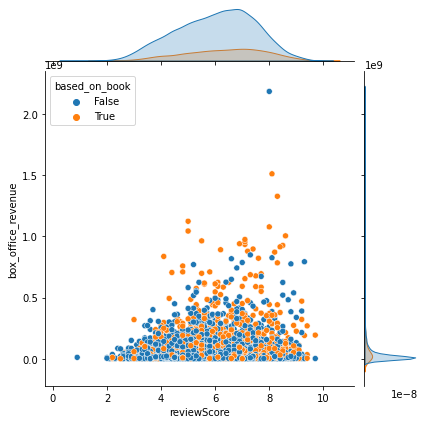

In [12]:
# Check the distribution of review scores and box revenues for book-based and not book-based films

sns.jointplot(data=books_movies, x='reviewScore', y='box_office_revenue', hue='based_on_book')

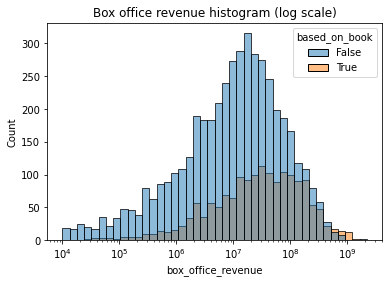

In [13]:
# Log scale is better for representing box office revenue

sns.histplot(data=books_movies, x='box_office_revenue', hue='based_on_book', log_scale=True)
plt.title('Box office revenue histogram (log scale)')
plt.show()

## Data Analysis for the datastory

In [14]:
# Create a dataframe where countries are not a list but each country is in a row.

books_countries = pd.merge(books_movies.drop('countries', axis=1), movie_countries, on='freebase_id', how='left')
countries = books_countries.groupby('countries')['wikipedia_id'].count().sort_values(ascending=False)
top_countries = countries[:15]
books_countries = books_countries.loc[books_countries['countries'].isin(top_countries.index)]
books_countries['countries'] = pd.Categorical(books_countries['countries'], top_countries.index)

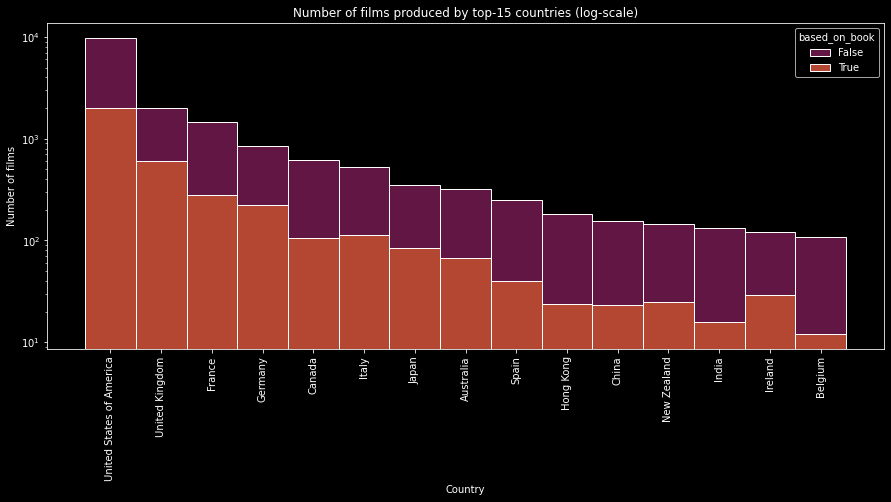

In [15]:
# Number of films produced by top-15 countries (log-scale)

plt.style.use('dark_background')

plt.figure(figsize=(15, 6))
sns.histplot(data=books_countries, x='countries', hue='based_on_book', multiple='stack', palette='rocket')
plt.xticks(rotation = 90)
plt.yscale('log')
plt.title('Number of films produced by top-15 countries (log-scale)')
plt.ylabel('Number of films')
plt.xlabel('Country')
plt.show()

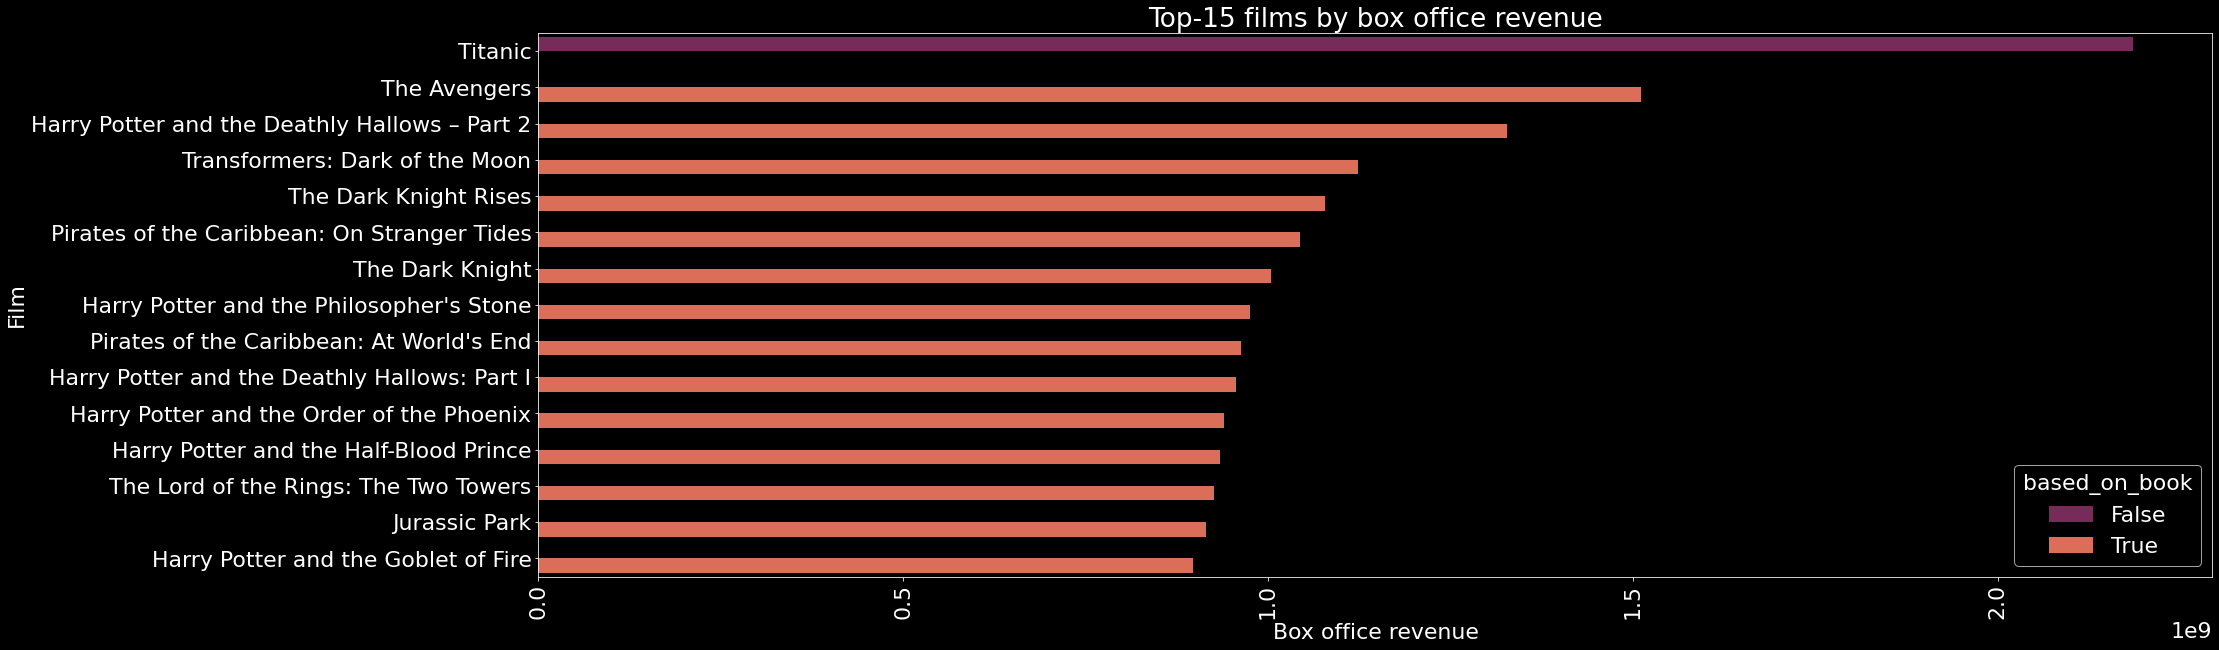

In [16]:
# Top-15 films by box office revenue
plt.style.use('dark_background')
plt.rcParams.update({'font.size': 22})

books_countries['based_on_book'] = books_countries['based_on_book'].astype(bool)
tmp = books_countries.sort_values(by='box_office_revenue', ascending=False).dropna(subset=['box_office_revenue', 'based_on_book'])[:25]#[['name', 'based_on_book', 'box_office_revenue']][:30]
plt.figure(figsize=(30, 10))
sns.barplot(data=tmp, x='box_office_revenue', y='name', hue='based_on_book', palette='rocket')
plt.title('Top-15 films by box office revenue')
plt.xlabel('Box office revenue')
plt.ylabel('Film')
plt.xticks(rotation = 90)
plt.show()

In [17]:
# Uploading BERT-preprocessed summaries (embeddings) and creating a merged dataframe.

#To avoid bert preprocessing, load data from the drive
data = pd.read_csv("/content/drive/MyDrive/ADA/WikiData/data_for_prediction.csv")
data = data.drop(columns=['Unnamed: 0'])

books_countries.dropna(subset=['summary', 'reviewScore', 'runtime', 'name'], inplace=True)
idx = movies_reviews.dropna(subset=['summary', 'reviewScore', 'runtime', 'name']).index

data_idx = data.index.intersection(set(idx))
book_idx = books_countries.index.intersection(set(idx))
final_idx = data_idx.intersection(set(book_idx))

data = data.loc[final_idx]
data_orig = books_countries.loc[final_idx]

data_orig.shape, data.shape

((6844, 19), (6844, 770))

In [18]:
!pip install psmpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=934a3269625b84f48bb44a319668aa6423dee0b480a63070e198ecde34208ff5
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn


In [19]:
# Propensity score calculation for based_on_book

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, accuracy_score

prop_data = data_orig[:500].copy()
X = data[:500].drop(['reviewScore'], axis=1)
y = prop_data['based_on_book']

model = LogisticRegression(max_iter=10000)
model.fit(X, y)
probs = model.predict_proba(X)[:, 1]

prop_data['propensity_score'] = probs

print(accuracy_score(probs > 0.5, y.values))

0.95


In [20]:
# Matching with PsmPy

data_psm = data.copy()
data_psm['based_on_book'] = data_orig['based_on_book']
data_psm.drop('reviewScore', axis=1, inplace=True)
data_psm = data_psm.reset_index()
data_psm[:2]

,index,0,1,2,3,4,5,6,7,8,...,760,761,762,763,764,765,766,767,runtime,based_on_book
0,0,1.586658,0.404240,1.401875,-1.885409,-2.075087,1.175769,-4.096477,-0.240483,1.377043,...,-1.203426,1.501957,2.181086,4.214947,3.708687,1.765725,-0.458318,0.306753,98.0,False
1,1,0.889685,-1.359997,-2.630267,-1.476290,-1.891712,0.113641,-3.632735,1.020376,-0.146364,...,1.600785,2.269267,4.141373,4.198636,4.973168,3.057245,-3.200186,3.140377,110.0,False


In [21]:
from psmpy import PsmPy
psm = PsmPy(data_psm, treatment='based_on_book',indx='index', exclude = [])

In [22]:
psm.logistic_ps(balance = True)

In [23]:
psm.knn_matched(matcher='propensity_logit', replacement=False, caliper=None)

In [24]:
indices = psm.matched_ids['index'].values.tolist() + psm.matched_ids['matched_ID'].values.tolist()

### Now we have matched data!!!

In [27]:
# Commented not to overwrite. Write the data.

matched_data = data_orig.loc[indices]
# matched_data.to_csv("/content/drive/MyDrive/ADA/WikiData/matched_books_data.csv")

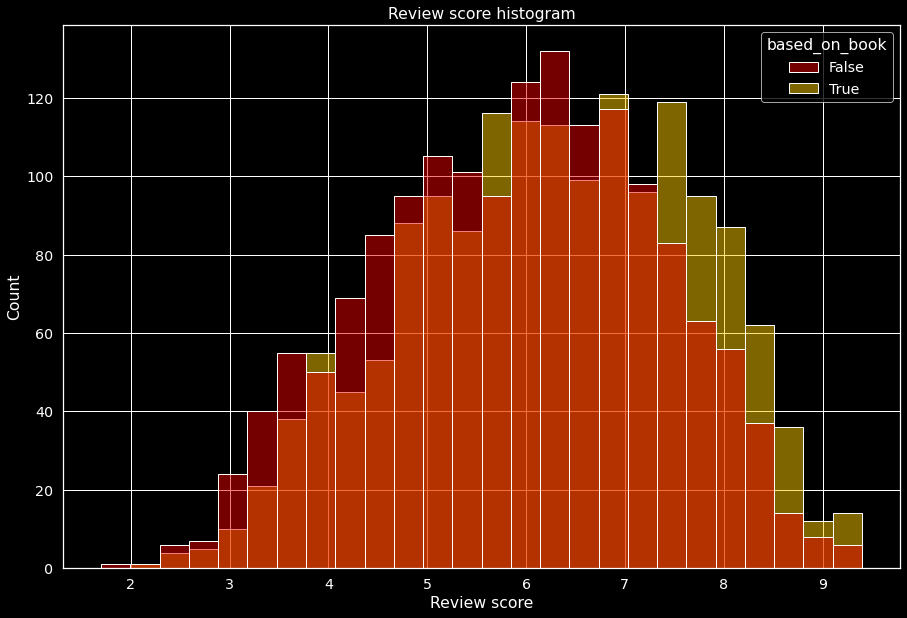

based_on_book
False    5.896215
True     6.259054
Name: reviewScore, dtype: float64


In [28]:
# Review score histogram

# sns.set_style('dark')
plt.figure(figsize=(15, 10))
plt.style.use("dark_background")
sns.histplot(data=matched_data, x='reviewScore', hue='based_on_book', palette='hot',)
plt.title('Review score histogram')
plt.xlabel('Review score')
plt.show()
print(data_orig.loc[indices].groupby('based_on_book')['reviewScore'].mean())

# Q3 What are the most representative words used in films versus in books (by different categories and countries)?



## Subtitles

### Movie subtitle analysis

As we have seen, movies based on books are more successful than regular movies. Let's examine movie subtitles to see if there is a difference in speech between books and non-book movies. Maybe the secret of success lies here?

We use the subtitle dataset, which is available at: https://www.kaggle.com/datasets/adiamaan/movie-subtitle-dataset

We merge this dataset with our source dataset. And then for the different subcategories of movies we count the wordcloud of the main words that appear in the subtitles of movies using the `tf-idf` model (we use `sklearn.feature_extraction.text.TfidfVectorizer`)

In [ ]:
# Load the data on subtitles and merge it with our main dataset 
# Using wikidata, we got the merge_ids table (in 'merge_ids.csv' file), which contains freebase_id and imdb_id
# Through this table, we are merging the dataset with subtitles with our original

subs_root = "drive/MyDrive/ADA/Subtitles/"

movies_subs_meta = pd.read_csv(subs_root + 'movies_meta.csv')
subtitles = pd.read_csv(subs_root + 'movies_subtitles.csv')

merge_ids = pd.read_csv(subs_root + 'merge_ids.csv')
merge_ids = merge_ids.rename(columns={'freebaseId': 'freebase_id', 'imdbId': 'imdb_id', })
merge_ids.head()

,filmLabel,freebase_id,imdb_id
0,Maximum Overdrive,/m/02dtms,tt0091499
1,Pirates of the Caribbean: The Curse of the Bla...,/m/01vksx,tt0325980
2,Plumíferos,/m/02q1ww9,tt0811021
3,Roadside Romeo,/m/02pp18f,tt1050739
4,Scarface,/m/01nln3,tt0086250


In [ ]:
# Get the dataset with all subtitles

movies_subs_all = pd.merge(left=movies_summaries, right=merge_ids, on='freebase_id')
movies_subs_all = pd.merge(left=movies_subs_all, right=subtitles, on='imdb_id')

movies_summaries.head()

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres,summary
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra..."


In [ ]:
# For each movie, combine all its subtitles into one row

def get_subs(df):
  # First, we take only the necessary columns from a large dataset with subtitles ('imdb_id', 'genres', 'text')
  subs = df[~df['text'].isnull()].loc[:, ['imdb_id', 'text']]

  # Grouping each movie separately
  subs = subs.groupby(['imdb_id'])

  # And make one row out of it
  subs = subs['text'].apply(list)
  subs = subs.apply(lambda y: ' '.join(y))
  subs = pd.DataFrame({'text': subs})

  # Add freebase_id to our table
  subs = subs.merge(df.loc[:, ['imdb_id', 'freebase_id']].drop_duplicates(), on='imdb_id')
  return subs

movie_subs = get_subs(movies_subs_all)
print(len(movie_subs))
movie_subs.head()

2942


,imdb_id,text,freebase_id
0,tt0002130,Downloaded from\nYTS.MX Official YIFY movies s...,/m/07jcl5
1,tt0005059,<i>And all I have to do today</i> <i>Is get pa...,/m/03gqqyf
2,tt0005060,"Τhis film was shot on location in Αndalucia, i...",/m/03gr41l
3,tt0009369,"Set dresser to the stage. Check lights. Hey, w...",/m/027xpn9
4,tt0011237,"No contemporary version of ""The Golem,\nhow he...",/m/0fpnj0


In [ ]:
# Combine subtitles with summaries so there's more data and more movies
movies_subs_summaries = pd.merge(left=movies_summaries.dropna(subset=['summary']), right=movie_subs, how='outer', on='freebase_id')

# Delete all movies with non-English subtitles, as well as nan values
english_ids = movie_languages[movie_languages.languages == 'English Language']
movies_subs_summaries = movies_subs_summaries[movies_subs_summaries.freebase_id.isin(english_ids.freebase_id)]
movies_subs_summaries = movies_subs_summaries.drop(movies_subs_summaries[movies_subs_summaries.genres.map(type) == float].index)

print(len(movies_subs_summaries))
movies_subs_summaries.head()

24775


,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres,summary,imdb_id,text
0,975900.0,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",NaN,NaN
1,9363483.0,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,tt0094320,"Hello? Oh. Karen, hi, listen. I'm so glad you ..."
3,18998739.0,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,[English Language],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns...",NaN,NaN
4,6631279.0,/m/0gffwj,Little city,1997-04-04,NaN,93.0,[English Language],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a...",NaN,NaN
5,171005.0,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,[English Language],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,NaN,NaN


Combine subtitles and summaries into a single `text`

In [ ]:
# Function that combines two columns (subtitles and summary) into one 
def combine_subs_and_summaries(df):
  subs_summary = df.loc[:, ['freebase_id', 'text', 'summary']]
  subs_summary = subs_summary.fillna('')
  subs_summary['subs_summary'] = subs_summary['summary'] + subs_summary['text']

  subs_summary = subs_summary.loc[:, ['freebase_id', 'subs_summary']]
  subs_summary = subs_summary.rename(columns={'subs_summary': 'text'})

  return subs_summary

movies_texts = combine_subs_and_summaries(movies_subs_summaries)

print(len(movies_texts))
movies_texts.head()

24775


,freebase_id,text
0,/m/03vyhn,"Set in the second half of the 22nd century, th..."
1,/m/0285_cd,A series of murders of rich young women throug...
3,/m/04jcqvw,"Every hundred years, the evil Morgana returns..."
4,/m/0gffwj,"Adam, a San Francisco-based artist who works a..."
5,/m/016ywb,{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...


Create two datasets: movies based on books (`movies_texts_on_book`) and movies not based on books (`movies_texts_wo_book`).

Both datasets have only id (`freebase_id`) and `text` (subtitles and sammaries)

In [ ]:
# Load book data 

book_root = "drive/MyDrive/ADA/WikiData/"

movies_books = pd.read_csv(book_root + 'films_books.csv')
movies_books = movies_books.rename(columns={'freebaseId': 'freebase_id'})

movies_texts_on_book = pd.merge(left=movies_texts, right=movies_books, on='freebase_id')
movies_texts_on_book = movies_texts_on_book.loc[:, ['freebase_id', 'text']]

movies_texts_on_book_ids = set(movies_texts_on_book.freebase_id)
movies_texts_wo_book = movies_texts.drop(movies_texts[movies_texts.freebase_id.isin(movies_texts_on_book_ids)].index)

print(len(set(movies_texts_wo_book.freebase_id)))
print(len(set(movies_texts_on_book.freebase_id)))
movies_texts_on_book.head()

21969
2806


,freebase_id,text
0,/m/016ywb,{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...
1,/m/05v5ws,"{{Plot}} Truck driver Martin ""Rubber Duck"" Pen..."
2,/m/0gm34c,"Miss Dove, commonly referred to as ""the terri..."
3,/m/01bwgr,"David Sumner , a timid American mathematician,..."
4,/m/01xlqd,"In the summer of 1959, local boy Danny Zuko a..."


In [ ]:
# Add dataset with movie scores
reviews = pd.read_csv(book_root + 'reviews_new.csv')
reviews = reviews.rename(columns={'freebaseId': 'freebase_id'})
reviews = reviews[reviews['reviewScore'].str.contains('/')]
reviews = reviews.drop(reviews[reviews.reviewScore.map(type) == float].index)

# Converting the value of the column to a float number
for i, row in reviews.iterrows():
  score, scale = row['reviewScore'].split('/')
  score, scale = float(score), float(scale)
  row['reviewScore'] = score / scale

print(len(reviews))
reviews.head()

17489


,filmLabel,freebase_id,reviewScore,time,timeLabel
0,Ichi,/m/0bmdc0z,0.57,2021-10-05T00:00:00Z,2021-10-05T00:00:00Z
1,Il Divo,/m/04lqvlr,0.75,2021-10-05T00:00:00Z,2021-10-05T00:00:00Z
2,Dying Breed,/m/04yb2dq,0.48,2021-10-05T00:00:00Z,2021-10-05T00:00:00Z
3,The Spy in Black,/m/04p50b,0.78,2021-10-05T00:00:00Z,2021-10-05T00:00:00Z
4,I Know Where I'm Going!,/m/03sndz,0.87,2021-10-05T00:00:00Z,2021-10-05T00:00:00Z


### Word processing

The subtitles are very greasy data. That's why it needs to be processed. 

To filter words, we use the `wordfreq` library, which counts the frequency of English words. We take words with `zipf_frequency` > 2. This includes almost all English words.

We also check the first letter of each word for non-captioning, to remove proper names (because there are a lot of them in subtitles, but they are not representative words).

We also remove short words. And swear words. There are a lot of them in subtitles. And they are even often representative. But we are decent people and don't want to look at them :)

In [ ]:
# List of swear words
BADWORDS = ['suck', 'stupid', 'pimp', 'dumb', 'homo', 'slut', 'damn', 'ass', 'rape', 'poop', 'cock', 'lol', 'crap', 'sex', 'nazi', 'neo-nazi', 'fuck', 'fucks', 'fucked', 'fucking', 'fuckin', 'bitch', 'pussy', 'penis', 'vagina', 'whore', 'nigger', 'nigga', 'niggers', 'cocksucker', 'assrape', 'motherfucker', 'motherfuckers', 'wanker', 'cunt', 'faggot', 'fags', 'asshole', 'piss', 'cum']

In [ ]:
import nltk
import string
from nltk.corpus import words
nltk.download('words')
from nltk.corpus import wordnet
nltk.download('omw-1.4')
nltk.download('wordnet')
from tqdm import tqdm
!pip install wordfreq
from wordfreq import zipf_frequency

# A function that filters the text of each row of the dataframe
def filter_words(df):
  for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    # Removing punctuation
    text = "".join([ch for ch in row['text'] if ch not in string.punctuation])
    # Delete all unnecessary words
    row['text'] = " ".join([word for word in text.split() if zipf_frequency(word, 'en') > 2 and word[0].islower() and len(word) > 3 and (word not in BADWORDS)])

  return df

# Create filtered datasets by books and not by books
movies_text_on_book = filter_words(movies_texts_on_book)
movies_text_wo_book = filter_words(movies_texts_wo_book)
movies_text_on_book.head()

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


100%|██████████| 21969/21969 [02:21<00:00, 155.80it/s]


,freebase_id,text
0,/m/016ywb,negotiations made named king both brief romant...
1,/m/05v5ws,driver driving through desert when woman passe...
2,/m/0gm34c,commonly referred terrible prim proper geograp...
3,/m/01bwgr,timid mathematician leaves chaos college antiw...
4,/m/01xlqd,summer local vacationing meet beach fall love ...


### TF-IDF

Functions for implementing the tf-ifd method

In [ ]:
from nltk.stem import SnowballStemmer, WordNetLemmatizer, PorterStemmer
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
from nltk.corpus import stopwords
import math
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')
import numpy as np

# We use PorterStemmer
stemmer = PorterStemmer()

# Tokenize
# Document processing function: word_tokenize and apply stemmer
def tokenize(text):
  tokens = nltk.word_tokenize(text)
  return " ".join([stemmer.stem(word.lower()) for word in tokens])

# Create a dictionary in which we store a dictionary for each key with frequencies for each word from topK
# The function takes a table (df_tfidf) as a result of tf-idf method.
# On the output it returns the dictionary with the most frequent words for each key
# Keys can be e.g. genres
def get_frequency(df_tfidf, keys, n):
  top_words = {}
  for id, row in df_tfidf.iterrows():
    word_frequency = {}
    for word in row['top']:
      word_frequency[word] = row[word]
      
    flag = 'b'
    if id // n > 0:
      flag = 'w'
    
    sum_freqs = 0
    for word in word_frequency:
      sum_freqs += word_frequency[word]
    for word in word_frequency:
      word_frequency[word] /= sum_freqs
    
    cur_id = int(id) % n
    if n == 1:
      cur_id = id
    top_words[keys[int(id) % n] + flag] = word_frequency
  
  return top_words


# TF-IDF algorithm
# The function takes as input texts - a list of documents. 
# The keys are the labels of each document (e.g. genres).
# The top-k is the number of the most frequent words we want to get for each document.
def get_top_words(texts, keys, top_k, max_df=0.8, n=-1):
  if n == -1:
    n = len(keys)

  # Using TfidfVectorizer
  tf = TfidfVectorizer(stop_words = 'english', max_df=max_df)
  features = tf.fit_transform(texts).toarray()

  # Create texts_tfidf table, which will store all tf-idf values, as well as the most common k words

  vocab = tf.vocabulary_
  reverse_vocab = {v:k for k, v in vocab.items()}

  feature_names = tf.get_feature_names()
  texts_tfidf = pd.DataFrame(features, columns = feature_names)

  # Save the most frequency words
  TOP_K = top_k
  idx = features.argsort(axis=1)
  tfidf_maxk = idx[:,-TOP_K:]

  texts_tfidf['top'] = [[reverse_vocab.get(item) for item in row] for row in tfidf_maxk]
  texts_tfidf.head()

  top_words = get_frequency(texts_tfidf, keys, n)
  return top_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Create masks for word clouds

In [ ]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from os import path

img_root = "drive/MyDrive/ADA/Images/"

threshold = 128
book_mask = np.array(Image.open(img_root + 'book_mask.jpg'))
book_mask[book_mask > threshold] = 255
book_mask[book_mask <= threshold] = 0

movie_mask = np.array(Image.open(img_root + 'movie_mask.png'))
movie_mask[movie_mask > threshold] = 255
movie_mask[movie_mask <= threshold] = 0

First, let's compare the word clouds built for all movies based on books and all movies not based on books. 

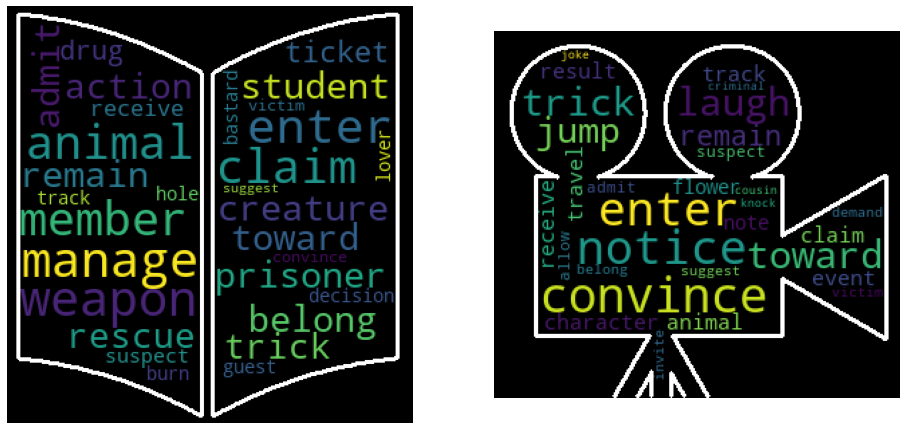

In [ ]:
import nltk
from nltk.corpus import stopwords

# Choose as many movies not based on books as there are based on books. For best results (to be balanced).
movies_text_wo_book = movies_text_wo_book.sample(n=len(movies_text_on_book), random_state=239)

# Bringing together the texts of all books-movie and not-books-movie
book_text = ' '.join(list(movies_text_on_book.text))
movie_text = ' '.join(list(movies_text_wo_book.text))

# Counting word frequencies
counter_book = Counter(book_text.split())
counter_movie = Counter(movie_text.split())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

stop_k = 1000
stopwords = list(STOPWORDS) + stopwords.words('english')

# Build clouds, while removing stop_k of the most frequent words 
# (they are very common words that are not representative)
wordcloud = WordCloud(background_color='black', contour_color='white', max_words=30, mask = book_mask, contour_width=3, 
                      stopwords=set(stopwords + [w for w, fr in counter_book.most_common()[:stop_k]])).generate(book_text)
ax1.imshow(wordcloud)
ax1.axis('off')

wordcloud = WordCloud(background_color='black', contour_color='white', max_words=30, mask = movie_mask, contour_width=3, 
                      stopwords=set(stopwords +  [w for w, fr in counter_movie.most_common()[:stop_k]])).generate(movie_text)
ax2.imshow(wordcloud)
ax2.axis('off')
plt.show()

From the looks of it, there is practically no difference, although the words of the movies based on the books seem a little more complicated.

### Genres

Let's now look at the most important words of the movies, grouped by genre. 

Could there be any difference?

In [ ]:
# For the 'genre', select all films of this genre and merge their subtitles into a single document
def get_subs_by_genre(df, genre):
  indices = movie_genres[movie_genres.genres == genre]
  df = df[df.freebase_id.isin(indices.freebase_id)]
  
  subs_list = df.text.values
  return ' '.join(subs_list)

In [ ]:
# Select the list of genres for which we want to calculate the main words
genres = ['Political cinema', 'Melodrama', 'Crime Fiction', 'Adventure', 'Detective', 'Musical', 'Science Fiction', 'War film']

# And we create a list of documents for each genre
# Based on books
texts_on_book = [get_subs_by_genre(movies_text_on_book, genre) for genre in genres]
# Not based on books
texts_wo_book = [get_subs_by_genre(movies_text_wo_book, genre) for genre in genres]

# The texts of movies not based on books are much longer (because there are more of them), so let's keep the same length
for i1, i2 in zip(range(len(texts_on_book)), range(len(texts_wo_book))):
  texts_wo_book[i2] = texts_wo_book[i2][:len(texts_on_book[i1])]

In [ ]:
# Create a single list of all texts
texts = texts_on_book + texts_wo_book

# Get the processed list of documents (texts)
texts = [tokenize(d) for d in tqdm([x.strip() for x in texts])]

100%|██████████| 16/16 [01:45<00:00,  6.62s/it]


In [ ]:
# Get a list of the most important words for each document (text)
top_words = get_top_words(texts, genres, 10, max_df=0.8)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Outputs word clouds grouped by genre. 

Since PorterStemmer greatly cuts the word, it is not always possible to understand the meaning of such a word. Let's find a word in our text from which we got the cut version and replace it with the original word for better understanding

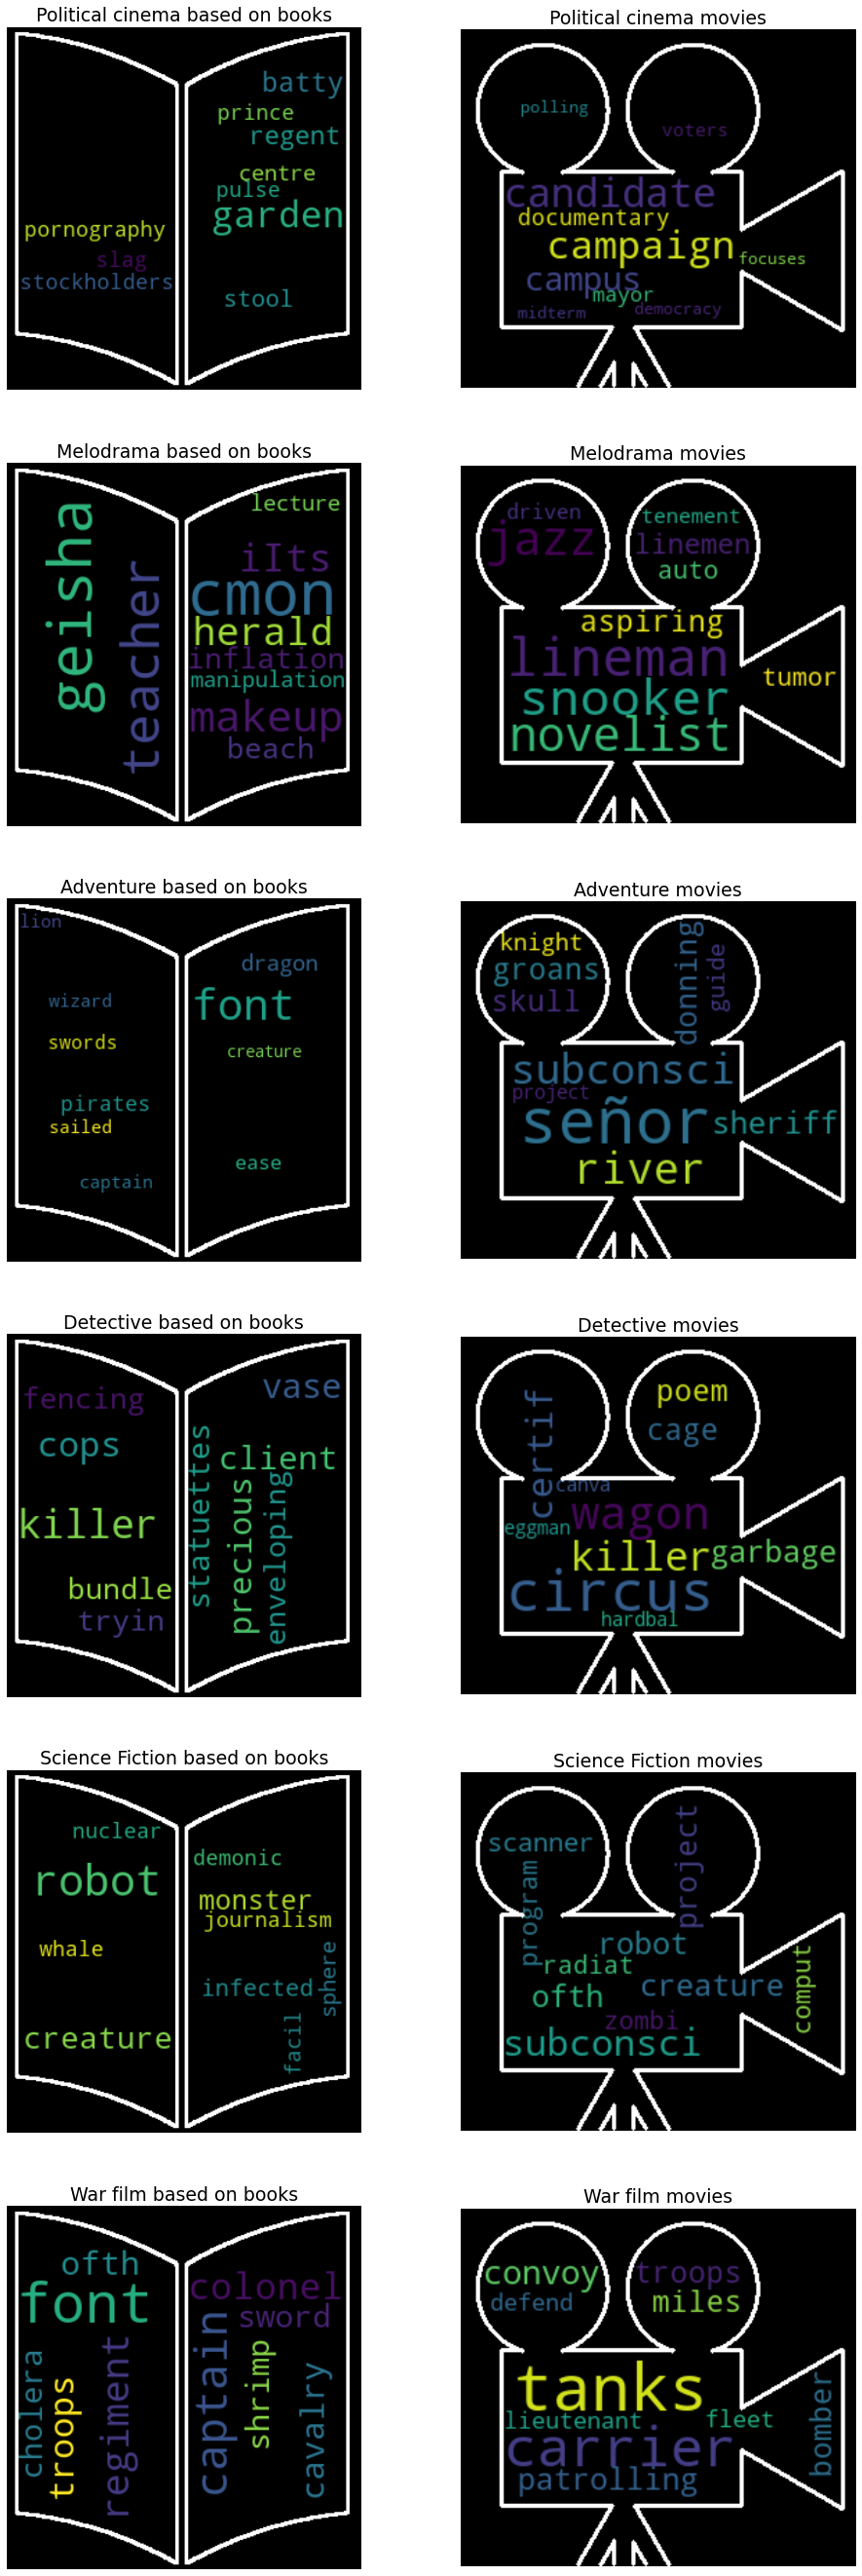

In [ ]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from os import path

# Genres for which we want to build a wordcloud
genres_for_plot = ['Political cinema', 'Melodrama', 'Adventure', 'Detective', 'Science Fiction', 'War film']

for i, genre in enumerate(genres_for_plot):
  text = (texts_on_book + texts_wo_book)[i]
  # Looking for some original word for our root (cut version) for the movies based in books
  current_top_words = list(top_words[genre + 'b'].keys())
  for top_word in current_top_words:
    for word in text.split():
      if stemmer.stem(word) == top_word:
        top_words[genre + 'b'][word] = top_words[genre + 'b'].pop(top_word)
        break

  text = (texts_on_book + texts_wo_book)[i + len(texts_on_book)]
  # Looking for some original word for our root (cut version) for the movies not based in books
  current_top_words = list(top_words[genre + 'w'].keys())
  for top_word in current_top_words:
    for word in text.split():
      if stemmer.stem(word) == top_word:
        top_words[genre + 'w'][word] = top_words[genre + 'w'].pop(top_word)
        break

# Build word plots
fig, axs = plt.subplots(len(genres_for_plot), 2, figsize=(16, len(genres_for_plot) * 8))
for i, genre in enumerate(genres_for_plot):
  if genre + 'b' in top_words:

    word_cloud_book = WordCloud(background_color='black', contour_color='white', mask=book_mask, contour_width=4).generate_from_frequencies(top_words[genre + 'b'])
    axs[i][0].imshow(word_cloud_book, interpolation='bilinear')
    axs[i][0].set_title(f'{genre} based on books', fontsize=19)
    axs[i][0].axis('off')
    
    word_cloud_movie = WordCloud(background_color='black', contour_color='white', mask=movie_mask, contour_width=3).generate_from_frequencies(top_words[genre + 'w'])
    axs[i][1].imshow(word_cloud_movie, interpolation='bilinear')
    axs[i][1].set_title(f'{genre} movies', fontsize=19)
    axs[i][1].axis('off')

plt.show()

Again, the difference is not very noticeable. Although the words on the right (for movies that are not based on books) are often more colloquial and slangy, and the words on the left (for movies based on books) are more literary. 

An interesting difference can be seen in the `Adventure` genre. Movies based on books seem to be more fantasy - about magic, wizards, pirates. And movies not based on books are more realistic - about the Middle Ages and the Wild West.

### Statistics by words

Let's try to find the difference in words numerically.

Let's calculate two statistics by words: the number of different (unique) words and the complexity of words.

Since the lengths of the texts are different, we will count the number of unique words in the window (the average value over all segments of the window length).

We calculate the complexity of words using the `word_frequency` function - the frequency of a word in English language. Considering that the more often a word occurs, the easier it is.

In [ ]:
# A function that calculates the average value of unique words across all rows of a table
# window - the length of the segment over which we calculate the average
def different_words(df, window):
  different_words_count = []
  for id, row in tqdm(df.iterrows(), total=df.shape[0]):
    text = tokenize(row['text']).split()
    current_different_words = []
    for i in range (0, len(text), window):
      words = text[i: i + window]
      if len(words) < window:
        continue
      counts = len(Counter(words))
      current_different_words.append(counts)
    if len(current_different_words) > 0:
      different_words_count.append(np.mean(current_different_words))
  return different_words_count


from wordfreq import word_frequency
# Calculate the average complexity of words for all rows of the table.
def word_complexity(df):
  complexity = []
  for id, row in tqdm(df.iterrows(), total=df.shape[0]):
    text = tokenize(row['text']).split()
    current_complexity = 0
    for word in text:
      # We normalize the function with a constant 10**5 so that there are no very small values
      current_complexity += word_frequency(word, 'en') * 10**5
    
    if current_complexity != 0:
      complexity.append(current_complexity / len(text))
  return complexity

In [ ]:
# Select 3 different windows for which we will count the number of unique words
windows = [100, 500, 1000]
different_words_on_book = []
for window in windows:
  different_words_on_book.append(different_words(movies_text_on_book, window))

different_words_without_book = []
for window in windows:
  different_words_without_book.append(different_words(movies_text_wo_book, window))

100%|██████████| 2916/2916 [00:48<00:00, 59.96it/s]


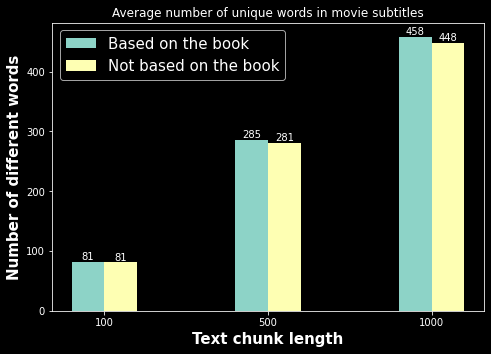

In [ ]:
# Calculate the average value
diff_words_mean = [[np.nanmean(diff_words) for diff_words in different_words_on_book],
                   [np.nanmean(diff_words) for diff_words in different_words_without_book]]

# Displaying charts
X = np.arange(3)
plt.style.use('dark_background')
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

bar_width = 0.1
on_book = ax.bar(X - bar_width, diff_words_mean[0], width=2 * bar_width, label='Based on the book')
without_book = ax.bar(X + bar_width, diff_words_mean[1], width=2 * bar_width, label='Not based on the book')

plt.xlabel('Text chunk length', fontweight ='bold', fontsize = 15)
plt.ylabel('Number of different words', fontweight ='bold', fontsize = 15)
plt.xticks([r for r in range(len(windows))], windows)

plt.legend(fontsize = 15)

def autolabel(values):
  """
  Attach a text label above each bar displaying its height
  """
  for value in values:
    height = value.get_height()
    ax.text(value.get_x() + value.get_width() / 2., height, '%d' % int(height), ha='center', va='bottom')

autolabel(on_book)
autolabel(without_book)

plt.title('Average number of unique words in movie subtitles')

plt.legend(fontsize = 15)
plt.show()

The book-movies have slightly more unique words. But the difference is very small

**Let**'s now look at the difference in word complexity.

To do this, we will create 2 other datasets - the most successful movies (movies with the highest rating) and the most unsuccessful movies (movies with the lowest rating)

In [ ]:
# Add rating to movies based on books
print(len(movies_text_on_book))
movies_text_on_book_rating = pd.merge(left=movies_text_on_book, right=reviews, on='freebase_id')
movies_text_on_book_rating = movies_text_on_book_rating.sort_values(by=['reviewScore'])
print(len(movies_text_on_book_rating))
movies_text_on_book_rating.head()

2916
2203


,freebase_id,text,filmLabel,reviewScore,time,timeLabel
1575,/m/08lzxj,after being shot down from kept alive coma abo...,King Kong Lives,0.22,2021-10-05T00:00:00Z,2021-10-05T00:00:00Z
1099,/m/0c3w0sx,garbage spaceship flying near where same garba...,The Garbage Pail Kids Movie,0.22,2021-10-09T00:00:00Z,2021-10-09T00:00:00Z
2169,/m/04n7n5z,obnoxious searching steady foundation life enc...,It's Pat,0.25,2021-10-09T00:00:00Z,2021-10-09T00:00:00Z
166,/m/090glv,film begins with planning take boat island rav...,House of the Dead,0.25,2021-10-06T00:00:00Z,2021-10-06T00:00:00Z
799,/m/0d71hm,terrified deaths four friends after they recei...,One Missed Call,0.26,2021-10-06T00:00:00Z,2021-10-06T00:00:00Z


In [ ]:
# Add rating to movies not based on books
print(len(movies_text_wo_book))
movies_text_wo_book_rating = pd.merge(left=movies_text_wo_book, right=reviews, on='freebase_id')
movies_text_wo_book_rating = movies_text_wo_book_rating.sort_values(by=['reviewScore'])
print(len(movies_text_wo_book_rating))
movies_text_wo_book_rating.head()

2916
997


In [ ]:
top_movies = 300
movies_text_on_book_top = movies_text_on_book_rating.tail(top_movies)
movies_text_on_book_bottom = movies_text_on_book_rating.head(top_movies)

movies_text_wo_book_top = movies_text_wo_book_rating.tail(top_movies)
movies_text_wo_book_bottom = movies_text_wo_book_rating.head(top_movies)

In [ ]:
word_complexity_on_book_all = np.mean(word_complexity(movies_text_on_book))
word_complexity_wo_book_all = np.mean(word_complexity(movies_text_wo_book))

100%|██████████| 2916/2916 [00:49<00:00, 58.34it/s]


In [ ]:
word_complexity_on_book_top = np.mean(word_complexity(movies_text_on_book_top))
word_complexity_wo_book_top = np.mean(word_complexity(movies_text_wo_book_top))

word_complexity_on_book_bottom = np.mean(word_complexity(movies_text_on_book_bottom))
word_complexity_wo_book_bottom = np.mean(word_complexity(movies_text_wo_book_bottom))

100%|██████████| 300/300 [00:08<00:00, 34.33it/s]


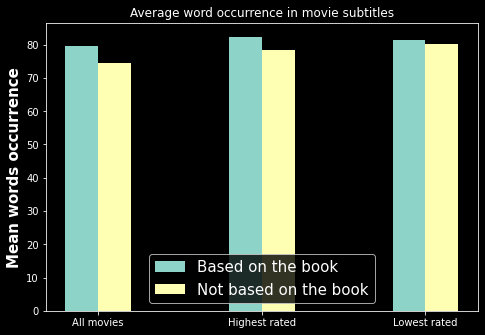

In [ ]:
complexity_words_mean = [[word_complexity_on_book_all, word_complexity_on_book_top, word_complexity_on_book_bottom],
                         [word_complexity_wo_book_all, word_complexity_wo_book_top, word_complexity_wo_book_bottom]]

X = np.arange(3)
plt.style.use('dark_background')
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

bar_width = 0.1
on_book = ax.bar(X - bar_width, complexity_words_mean[0], width=2 * bar_width, label='Based on the book')
without_book = ax.bar(X + bar_width, complexity_words_mean[1], width=2 * bar_width, label='Not based on the book')

plt.ylabel('Mean words occurrence', fontweight ='bold', fontsize = 15)
plt.xticks([r for r in range(len(complexity_words_mean[0]))], ['All movies', 'Highest rated', 'Lowest rated'])

plt.title('Average word occurrence in movie subtitles')

plt.legend(fontsize = 15)
plt.show()

As we can see, the situation is even reversed here - in films based on books, slightly easier and more common vocabulary is used (since the larger the number, the more common the word, which means it is easier).

However, the difference is again insignificant.

And it doesn't matter if the movie is successful or not - all values are very similar.

And now let's build word clouds for these 2 datasets: for successful and unsuccessful films

Create 4 documents: successful and unsuccessful films based on books and not

In [ ]:
def get_text(df):
  return ' '.join(df.text.values)

In [ ]:
texts = [get_text(movies_text_on_book_top),
         get_text(movies_text_on_book_bottom),
         get_text(movies_text_wo_book_top),
         get_text(movies_text_wo_book_bottom)]

# Get the processed list of documents
texts = [tokenize(d) for d in tqdm([x.strip() for x in texts])]

100%|██████████| 4/4 [00:58<00:00, 14.50s/it]


In [ ]:
# Applying the td-idf algorithm
labels = ['Highest rated', 'Lowest rated']
top_words = get_top_words(texts, labels, 10, max_df=1)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Build word clouds in the same way as word clouds grouped by genre (which we described above)

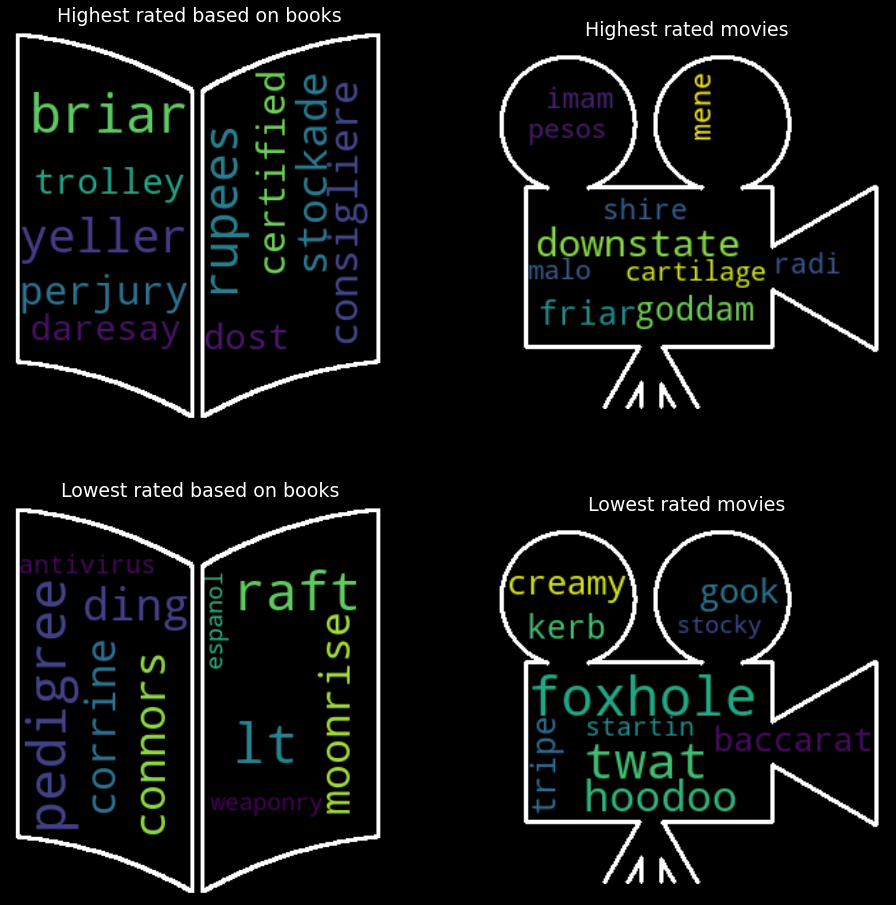

In [ ]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from os import path

texts = [get_text(movies_text_on_book_top),
         get_text(movies_text_on_book_bottom),
         get_text(movies_text_wo_book_top),
         get_text(movies_text_wo_book_bottom)]
         
# Returning words to their original form
for i, isTop in enumerate(labels):
  text = texts[i]

  current_top_words = list(top_words[isTop + 'b'].keys())
  for top_word in current_top_words:
    for word in text.split():
      if stemmer.stem(word) == top_word:
        top_words[isTop + 'b'][word] = top_words[isTop + 'b'].pop(top_word)
        break

  text = texts[i + len(labels)]

  current_top_words = list(top_words[isTop + 'w'].keys())
  for top_word in current_top_words:
    for word in text.split():
      if stemmer.stem(word) == top_word:
        top_words[isTop + 'w'][word] = top_words[isTop + 'w'].pop(top_word)
        break

# Build word plots
fig, axs = plt.subplots(len(labels), 2, figsize=(16, len(labels) * 8))
for i, isTop in enumerate(labels):
  if isTop + 'b' in top_words:
    word_cloud_book = WordCloud(background_color='black', contour_color='white', mask=book_mask, contour_width=4).generate_from_frequencies(top_words[isTop + 'b'])
    axs[i][0].imshow(word_cloud_book, interpolation='bilinear')
    axs[i][0].set_title(f'{isTop} based on books', fontsize=19)
    axs[i][0].axis('off')
    
    word_cloud_movie = WordCloud(background_color='black', contour_color='white', mask=movie_mask, contour_width=3).generate_from_frequencies(top_words[isTop + 'w'])
    axs[i][1].imshow(word_cloud_movie, interpolation='bilinear')
    axs[i][1].set_title(f'{isTop} movies', fontsize=19)
    axs[i][1].axis('off')

plt.show()

Here the difference in word style is more noticeable: on the right (films not based on the book) words are colloquial, and on the left (films based on the books) words are rarer, more beautiful and more literary.

Summing up the analysis of subtitles, there is a small difference in the speech used in movies based on books compared to other movies.

Specifically, the movies based on books use a slightly more varied and complex vocabulary and contain less jargon and swear words. However, the difference is negligible, so it is not clear whether the style of speech is a significant factor in the success of these movies. It is possible that other factors, such as the plot, the acting, the direction, and the marketing, maybe more important in determining the success of movies based on books.

# Q2 Can we predict the movie review score based on our data? Can we predict the movie review score based on our data and does the fact that a movie is based on a book story improves the score in comparison with other movies?

In [29]:
#Select features for predictions
data_for_prediction = movies_reviews[['summary', 'reviewScore', 'runtime', 'name', 'freebase_id', 'release_date']]
data_for_prediction = data_for_prediction.dropna()
data_for_prediction

,summary,reviewScore,runtime,name,freebase_id,release_date
0,"Set in the second half of the 22nd century, th...",3.8,98.0,Ghosts of Mars,/m/03vyhn,2001-08-24
1,A series of murders of rich young women throug...,5.8,110.0,White Of The Eye,/m/0285_cd,1987-01-01
4,{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,8.2,137.0,Henry V,/m/016ywb,1989-11-08
6,Jimmy ([[Hiroshi Watanabe loves dinosaurs and...,6.0,82.0,White on Rice,/m/05p45cv,2009-01-01
7,A young 20-year-old named Jody lives with his...,6.2,123.0,Baby Boy,/m/014k4y,2001-06-27
...,...,...,...,...,...,...
13979,"Joe Morton stars in this dramatic comedy, set ...",7.1,104.0,The Brother from Another Planet,/m/05mc7l,1984-09-07
13981,"The space armada from Mars, known as the Imper...",3.8,100.0,Spaced Invaders,/m/0kvgqb,1990-01-01
13982,Havoc is wrought on the inhabitants of a small...,7.3,106.0,State and Main,/m/0660qx,2000-08-26
13983,Jennifer Haines is an up-and-coming Chicago a...,5.3,107.0,Guilty as Sin,/m/030xw6,1993-06-04


### To use summaries for predictions we will convert them into feature vectors using BERT

In [30]:
!pip install pytorch-pretrained-bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 4.9 MB/s 
     |████████████████████████████████| 132 kB 35.5 MB/s 
     |████████████████████████████████| 79 kB 8.2 MB/s 
     |████████████████████████████████| 10.3 MB 58.0 MB/s 
     |████████████████████████████████| 140 kB 57.1 MB/s 
     |████████████████████████████████| 127 kB 74.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [31]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

In [32]:
def texts_to_lists(text, text_size):
    # If our text longer then 512, we split it into parts, 
    # because pretrained BERT can't produce texts longer than 512
    result = []
    number_of_splits = (len(text) // text_size) + 1
    for i in range(number_of_splits):
        part = text[i*text_size:min((i+1)*text_size, len(text))]
        result.append(part)
    return result

In [33]:
def text_to_embedding(text, tokenizer, model, text_size=512):   
    # Add cls and sep tokens to each text (required for bert)
    text_sep = "[CLS] " + text + " [SEP]"

    #Split each text into tokens
    tokenized_text = tokenizer.tokenize(text_sep)

    #Set index to each token
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

    #Set 1, because we analyze each text separately as a single structure
    segments_ids = [1] * len(indexed_tokens)

    #Convert tokens and segments to torch tensors  
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensor = torch.tensor([segments_ids])

    #Apply bert model to the corpus of texts
    model.eval()

    #Move tensors to available device (cuda is better, because can take too much time on cpu)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    tokens_tensor = tokens_tensor.to(device)
    segments_tensor = segments_tensor.to(device)
    model.to(device)
    
    with torch.no_grad():
        embedding = model(tokens_tensor, segments_tensor)[1][0].cpu()
    return embedding

In [34]:
def summary_embeddings(summaries, tokenizer, model, text_size=512):
    lists_of_texts = summaries.apply(lambda x: texts_to_lists(x, text_size))
    embeddings = lists_of_texts.apply(lambda x: [text_to_embedding(text, tokenizer, model) for text in x])
    
    #Let's try the simpliest way of aggregating: sum
    embeddings_aggregated = embeddings.apply(lambda x: sum(x))
    return embeddings_aggregated

In [35]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')

100%|██████████| 407873900/407873900 [00:08<00:00, 49657850.96B/s]


In [ ]:
# Convert summaries to embeddings
embeddings = summary_embeddings(data_for_prediction.summary, tokenizer, model, text_size=512)

In [ ]:
data_for_prediction = data_for_prediction.assign(summary_embds=embeddings)
embds_columns = data_for_prediction.summary_embds.apply(pd.Series)
data_to_save = embds_columns.assign(freebase_id=data_for_prediction.freebase_id)
data_to_save = pd.merge(left=data_to_save, right=data_for_prediction, on='freebase_id')
data = data_to_save
# data_to_save.to_csv('/content/drive/MyDrive/ADA/WikiData/data_for_prediction_new.csv')  

In [37]:
# To avoid bert preprocessing each time, load data from the drive
# Comment this cell, if run all preprocessing steps

data = pd.read_csv("/content/drive/MyDrive/ADA/WikiData/data_for_prediction_new.csv")
data = data.drop(columns=['Unnamed: 0'])

### Try several different machine learning models to solve the review score prediction problem

1. TabNet - neural network for tabular data

In [38]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [39]:
X = data.drop(columns=['reviewScore', 'freebase_id', 'summary', 'name', 'release_date', 'summary_embds'])
y = data[['reviewScore']]

### Firstly, let's look on the distribution of review scores

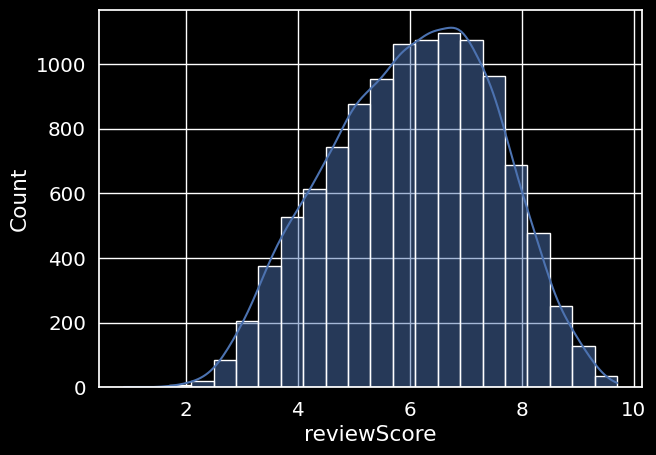

In [40]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=100)
plt.rcParams.update({'font.size': 17})
sns.histplot(data=data, x='reviewScore', kde=True, ax=ax, binwidth=0.4, palette='rocket')

# Looks a little skewed to higher scores. Perhaps this means that people are more likely to give higher view scores than lower ones.

#### Data preprocessing

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_test_table = y_test

In [42]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy().reshape(-1, 1)
X_test = X_test.to_numpy()
y_test = y_test.to_numpy().reshape(-1, 1)

In [43]:
# Install and import TabNet
!pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 567 kB/s 


In [44]:
regressor = TabNetRegressor(verbose=0,seed=42)
regressor.fit(X_train=X_train, y_train=y_train,
          eval_set=[(X_test, y_test)],
          patience=200, max_epochs=2000,
          eval_metric=['rmse'])


Early stopping occurred at epoch 450 with best_epoch = 250 and best_val_0_rmse = 1.27096


/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [45]:
preds_tabnet = regressor.predict(X_test)

In [46]:
mse = mean_squared_error(y_test, preds_tabnet)
print("TabNet MSE test loss =", mse)
r_2 = r2_score(y_test, preds_tabnet)
print("TabNet R^2 score =", r_2)
Adj_r2 = 1 - (1-r2_score(y_test, preds_tabnet)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("TabNet adjusted R^2 score =", Adj_r2)
mae = mean_absolute_error(y_test, preds_tabnet)
print("MAE =", mae)

TabNet MSE test loss = 1.6153466882218668
TabNet R^2 score = 0.26921811925081107
TabNet adjusted R^2 score = 0.215661341751895
MAE = 1.0257490011199124


In [47]:
metrics_preds = pd.DataFrame(columns=['Regressor', 'MSE_loss', 'R_2', 'Adj_R_2', 'MAE'])
metrics_preds.loc[len(metrics_preds.index)] = ['TabNet', mse, r_2, Adj_r2, mae]

2. Random Forest

In [48]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)
regr.fit(X_train, y_train)

<ipython-input-48-616c9159a6f5>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, random_state=0)

In [49]:
preds = regr.predict(X_test)
mse = mean_squared_error(y_test, preds)
r_2 = r2_score(y_test, preds)
Adj_r2 = 1 - (1-r2_score(y_test, preds)) * (len(y)-1)/(len(y)-X.shape[1]-1)
mae = mean_absolute_error(y_test, preds)

In [50]:
metrics_preds.loc[len(metrics_preds.index)] = ['Random Forest', mse, r_2, Adj_r2, mae]

3. Gradient Boosting

In [51]:
#Fast GB (better for datasets with intermediate size)
from sklearn.ensemble import HistGradientBoostingRegressor
est = HistGradientBoostingRegressor().fit(X_train, y_train)
preds = est.predict(X_test)
est.score(X_test, y_test)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.20796804418750936

In [52]:
preds = est.predict(X_test)
mse = mean_squared_error(y_test, preds)
r_2 = r2_score(y_test, preds)
Adj_r2 = 1 - (1-r2_score(y_test, preds)) * (len(y)-1)/(len(y)-X.shape[1]-1)
mae = mean_absolute_error(y_test, preds)

In [53]:
metrics_preds.loc[len(metrics_preds.index)] = ['Gradient Boosting', mse, r_2, Adj_r2, mae]

4. Simple MLP

In [54]:
# Here there is an idea, that BERT embeddings has aggregate a lot of information, and probably it is better to choose not very difficult model

In [55]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn import functional as F

In [56]:
# Dataset class
class TabDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]).float(), torch.tensor(self.y[idx]).float()

In [57]:
# Construct a simple neural network
class Net(nn.Module): 
    def __init__(self,input_shape):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_shape, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [58]:
train_data = TabDataset(X_train, y_train)
test_data = TabDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [59]:
# Hyperparameters
learning_rate = 0.001
epochs = 200
# Model , Optimizer, Loss
model = Net(input_shape=X_train.shape[1])
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()

In [60]:
losses = []
accur = []
# Train loop
for i in range(epochs):
    for j, (x_batch,y_batch) in enumerate(train_loader):
    
        #calculate output
        output = model(x_batch)
        #calculate loss
        loss = loss_fn(output, y_batch.reshape(-1,1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if i % 10 == 0:
        losses.append(loss.item())

In [61]:
preds = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()
mse = mean_squared_error(y_test, preds)
r_2 = r2_score(y_test, preds)
Adj_r2 = 1 - (1-r2_score(y_test, preds)) * (len(y)-1)/(len(y)-X.shape[1]-1)
mae = mean_absolute_error(y_test, preds)

In [62]:
metrics_preds.loc[len(metrics_preds.index)] = ['MLP', mse, r_2, Adj_r2, mae]

In [63]:
#Results for all approaches
metrics_preds
#metrics_preds.to_csv('/content/drive/MyDrive/ADA/WikiData/metrics_prediction.csv')  

,Regressor,MSE_loss,R_2,Adj_R_2,MAE
0,TabNet,1.615347,0.269218,0.215661,1.025749
1,Random Forest,1.816454,0.178237,0.118013,1.101564
2,Gradient Boosting,1.750736,0.207968,0.149922,1.076875
3,MLP,1.881648,0.148744,0.086358,1.133746


#### In conclusion we have that the best result is obtained using the TabNet network. It is worth noting that we did not use movie titles in this notebook, as they even slightly worsened the result.

### Analysis of predictions for different genres on the test subset

In [64]:
import json
from itertools import compress

In [68]:
test

,reviewScore,prediction,0,1,2,3,4,5,6,7,...,764,765,766,767,freebase_id,summary,runtime,name,release_date,summary_embds
6927,8.8,6.793893,0.077878,-0.153633,0.054449,-0.324287,-0.353232,0.216834,-0.648270,0.153682,...,1.625929,0.081226,-0.389259,0.840347,/m/02q9vkd,"In 1616, when Flanders is under Spanish occupa...",95.0,Carnival in Flanders,1935-12-03,"tensor([ 7.7878e-02, -1.5363e-01, 5.4449e-02,..."
1669,3.2,5.076874,2.071530,-0.154200,1.624459,-2.755403,-3.097456,1.130977,-4.023489,-0.139522,...,3.802709,3.131837,-1.125682,1.266708,/m/053xf9,"{{plot}} The movie opens with Joe Tyler , a pr...",99.0,Serving Sara,2002-08-20,"tensor([ 2.0715e+00, -1.5420e-01, 1.6245e+00,..."
9499,4.4,5.514338,0.569398,-2.239755,-2.509058,-1.903579,0.021273,-0.667240,-4.003720,1.785875,...,5.510433,1.716361,-4.026930,2.804520,/m/05b08zq,"In 2007, John Tyree , a Staff Sergeant in the ...",108.0,Dear John,2010-01-24,"tensor([ 0.5694, -2.2398, -2.5091, -1.9036, 0..."
3287,6.3,6.971964,0.000001,-0.615993,0.098016,-0.588741,-0.647243,0.059680,-1.087586,0.425755,...,1.997823,0.090899,-0.779451,1.182829,/m/069qyv,The movie is a farce about a mentally unstable...,95.0,How to Get Ahead in Advertising,1989-05-05,"tensor([ 1.2517e-06, -6.1599e-01, 9.8016e-02,..."
2973,7.2,6.478749,-0.282303,-0.392672,-0.676038,0.115292,0.045546,-0.079020,-0.479035,0.270099,...,0.411298,-0.675348,-0.502179,0.327101,/m/04zww8x,"Seong-nam, a painter in his forties, travels t...",115.0,Night and Day,2008,"tensor([-2.8230e-01, -3.9267e-01, -6.7604e-01,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5470,4.0,5.187729,-0.418945,-1.838258,-1.184657,-1.170526,-0.477669,0.219504,-3.586213,1.165972,...,5.248832,1.857590,-3.529403,3.817217,/m/027nr4g,Social worker Emily Jenkins is assigned to in...,109.0,Case 39,2009-08-13,"tensor([-4.1894e-01, -1.8383e+00, -1.1847e+00,..."
10034,7.7,7.233900,0.542801,-0.550301,0.062360,-0.976908,-1.986745,0.202993,-3.309601,0.938942,...,4.304655,2.006575,-2.124664,2.186006,/m/0fcj9r,La Cérémonie tells the story of an illiterate ...,102.0,La Cérémonie,1996,"tensor([ 0.5428, -0.5503, 0.0624, -0.9769, -1..."
8610,4.0,5.809465,1.133062,-1.606814,-2.136951,-1.542383,-1.342254,1.039918,-5.046697,0.250882,...,6.195478,1.101758,-3.177233,2.058435,/m/04x7w0,"In the year 2009, the super-wealthy gain immor...",110.0,Freejack,1992-01-17,"tensor([ 1.1331e+00, -1.6068e+00, -2.1370e+00,..."
6339,6.1,6.789785,-0.698283,-1.150620,-1.217771,-0.063977,-0.036227,0.027943,-0.940039,0.810318,...,3.062035,-0.440209,-1.958904,1.961383,/m/09g7tyq,"In Berlin, the pederast serial killer Gabriel ...",128.0,Antibodies,2005,"tensor([-0.6983, -1.1506, -1.2178, -0.0640, -0..."


In [69]:
preds_test = regressor.predict(X_test)
test_preds = y_test_table.assign(prediction=preds_test)
test = test_preds.join(data[[col for col in data.columns if col != "reviewScore"]], how="left")
#test_preds_genres = test.assign(genres=movies_summaries.apply(lambda m: list((json.loads(m.genres)).values()), axis=1))
test_preds_genres = test.assign(genres=movies_summaries.genres)
test_preds_genres_exp = test_preds_genres.explode('genres').dropna()

In [70]:
mask = test_preds_genres_exp.groupby('genres').reviewScore.count() > 250
mask = mask.tolist()

#Find the most frequent genres in the test subset
keys = list(test_preds_genres_exp.groupby('genres').groups.keys())
genres_freq = list(compress(keys, mask))
genres_freq

['Black-and-white', 'Comedy', 'Drama', 'Romance Film']

In [71]:
test_frequent_genres = test_preds_genres_exp.loc[test_preds_genres_exp['genres'].isin(genres_freq)]

In [72]:
# Calculate Pearson correlation for predictions and review scores for the most frequent genres in the test subset
corr_frequent = test_frequent_genres.groupby('genres')[['reviewScore','prediction']].corr().unstack().iloc[:,1].dropna()
corr_frequent.sort_values(inplace=True, ascending=False)

Drama
Pearson correlation = 0.5156089870102782


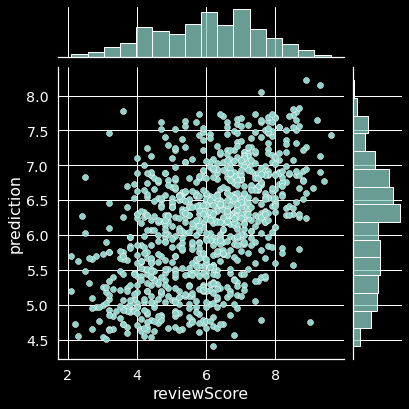

In [73]:
#Plot top-2 genres with highest correlation btw predictions and review scores

print(corr_frequent.keys()[0])
print("Pearson correlation =", corr_frequent[0])
plt.rcParams.update({'font.size': 17})
plt.style.use("dark_background")
sns.jointplot(data=test_frequent_genres[test_frequent_genres.genres == corr_frequent.keys()[0]], x="reviewScore", y="prediction", palette='rocket')

Comedy
Pearson correlation = 0.5061748117195592


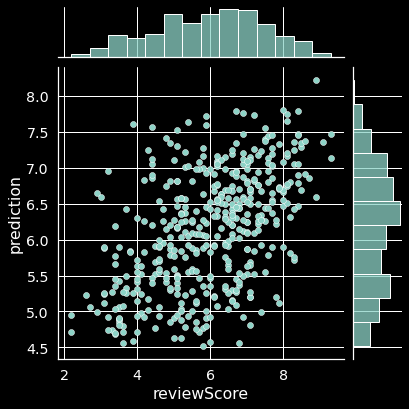

In [74]:
print(corr_frequent.keys()[1])
print("Pearson correlation =", corr_frequent[1])
sns.jointplot(data=test_frequent_genres[test_frequent_genres.genres == corr_frequent.keys()[1]], x="reviewScore", y="prediction", palette='rocket')

### Ananlysis for movies, which are based on books

In [75]:
# Load the book dataset
book_root = "drive/MyDrive/ADA/WikiData/"
movies_books = pd.read_csv(book_root + 'films_books.csv')
movies_books = movies_books.rename(columns={'freebaseId': 'freebase_id'})
movies_books = movies_books.drop(columns=['filmLabel'])

In [78]:
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

In [79]:
data_with_books = pd.merge(left=data, right=movies_books, on='freebase_id', how='left')
data_with_books['based_on_book'] = np.where(data_with_books.bookLabel.isna(), 0, 1)
data_for_reg = data_with_books.drop(columns=['freebase_id', 'summary', 'runtime', 'name', 'release_date', 'summary_embds', 'bookLabel'])

In [80]:
X = data_for_reg.drop(columns=['reviewScore'])
y = data_for_reg.reviewScore

In [81]:
mod = sm.OLS(y, sm.add_constant(X))
res = mod.fit()
print(res.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:            reviewScore   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     5.803
Date:                Fri, 23 Dec 2022   Prob (F-statistic):               0.00
Time:                        22:02:13   Log-Likelihood:                -18431.
No. Observations:               11351   AIC:                         3.840e+04
Df Residuals:                   10581   BIC:                         4.405e+04
Df Model:                         769                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.8652      0.046    128.287

It turned out that if we predict the rating by the summary and the fact that the film was made based on the book or not, then this fact is statistically significant in predictions. The table shows that films based on the book receive an additional 0.23 points.

# Q4 In this part, we are interested to compare the scores of movies and their book counterparts. We all know a person who says "the book was better", well, we want to know if that's true.

In [82]:
import re
import gensim as gensim
from gensim.utils import simple_preprocess
import json
from functools import partial
!pip install fuzzymatcher
import fuzzymatcher
import scipy.stats as stats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.2 MB 4.9 MB/s 
     |████████████████████████████████| 174 kB 64.4 MB/s 
  Created wheel for metaphone: filename=Metaphone-0.6-py3-none-any.whl size=13919 sha256=63cbaa7eb067666bc83b3e6515a4f9a8ac9db97108ba47d5dcae45eb30e8248a
  Stored in directory: /root/.cache/pip/wheels/ea/4e/3b/0634f08a7980461ad630fa4147cbd25913b008b4a02992ba66
Successfully built metaphone


In [83]:
# Load oscars data
oscars = pd.read_csv(Path(wikidata_root, 'oscars_new.csv'))
oscars['awardwin'] = oscars['awardLabel'].notna()
oscar = oscars.drop_duplicates(subset=["freebaseId"], keep='first')
awards = oscar[['freebaseId', 'awardwin']]
awards.head()

print(f'Size of awards dataframe: {len(awards)}')
awards.head()

Size of awards dataframe: 857


,freebaseId,awardwin
0,/m/09gq0x5,True
2,/m/0jvt9,True
3,/m/09m6kg,True
4,/m/07j8r,True
5,/m/0sxmx,True


In [84]:
# merge oscars and movie review data
movies_reviews = movies_reviews[['name','freebase_id', 'reviewScore']]
df_movie_score = pd.merge(left=movies_reviews, right=awards, left_on='freebase_id', right_on='freebaseId', how='left')
df_movie_score=df_movie_score.drop(['freebaseId'], axis=1)
df_movie_score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13985 entries, 0 to 13984
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         13985 non-null  object 
 1   freebase_id  13985 non-null  object 
 2   reviewScore  13985 non-null  float64
 3   awardwin     703 non-null    object 
dtypes: float64(1), object(3)
memory usage: 546.3+ KB


In [85]:
# load book label and merge with the previous dataset
books = pd.read_csv(Path(wikidata_root, 'films_books.csv'))
df_movie_book = pd.merge(left=df_movie_score, right=books, left_on='freebase_id', right_on='freebaseId', how='left')
df_movie_book['based_on_book'] = df_movie_book['bookLabel'].notna()

print(f'size of movies reviews dataframe: {len(movies_reviews)}')
print(f'size of movies dataframe: {len(df_movie_score)}')
print(f'size of books dataframe: {len(books)}')
print(f'size of df_full dataframe: {len(df_movie_book)}')
df_movie_book.head()

size of movies reviews dataframe: 13985
size of movies dataframe: 13985
size of books dataframe: 7017
size of df_full dataframe: 14087


,name,freebase_id,reviewScore,awardwin,filmLabel,freebaseId,bookLabel,based_on_book
0,Ghosts of Mars,/m/03vyhn,3.8,NaN,NaN,NaN,NaN,False
1,White Of The Eye,/m/0285_cd,5.8,NaN,NaN,NaN,NaN,False
2,Alexander's Ragtime Band,/m/02qc0j7,7.0,True,NaN,NaN,NaN,False
3,City of the Dead,/m/075f66,5.9,NaN,NaN,NaN,NaN,False
4,Henry V,/m/016ywb,8.2,True,Henry V,/m/016ywb,Henry V,True


In [86]:
df_movie_book=df_movie_book.drop(['freebaseId'], axis=1)
df_movie_book.rename(columns = {'name': 'movie_name', 'filmLabel':'film_label', 'bookLabel':'book_label', 'reviewScore':'movie_score', 'awardwin':'movie_award'}, inplace = True)
df_movie_book.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14087 entries, 0 to 14086
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_name     14087 non-null  object 
 1   freebase_id    14087 non-null  object 
 2   movie_score    14087 non-null  float64
 3   movie_award    717 non-null    object 
 4   film_label     2729 non-null   object 
 5   book_label     2729 non-null   object 
 6   based_on_book  14087 non-null  bool   
dtypes: bool(1), float64(1), object(5)
memory usage: 784.1+ KB


In [87]:
import os
path= "drive/MyDrive/ADA/Adata"
df_movie_book.to_csv(os.path.join(path,r'df_movie_book.csv'))

### MOVIE SCORE DATASET

In [88]:
# Loading dataset (saved previously)
wikibook = "drive/MyDrive/ADA/Adata"
movies = pd.read_csv(Path(wikibook, 'df_movie_book.csv')) 
movies=movies.drop(['Unnamed: 0', 'film_label'], axis=1)
dfm = movies.copy()
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14087 entries, 0 to 14086
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_name     14087 non-null  object 
 1   freebase_id    14087 non-null  object 
 2   movie_score    14087 non-null  float64
 3   movie_award    717 non-null    object 
 4   book_label     2729 non-null   object 
 5   based_on_book  14087 non-null  bool   
dtypes: bool(1), float64(1), object(4)
memory usage: 564.2+ KB


In [89]:
# Preprocessing of title for movies
dfm['book_label']=dfm['book_label'].str.lower()
dfm['book_label'].replace(to_replace="[\(\[].*?[\)\]]", value=r"", regex=True, inplace=True)  # remove parentheses and brackets
dfm['book_label'].replace({'\d+[\/:\-]\d+[\/:\-\s]*[\dAaPpMm]*' : '', '\w+\s\d+[\,]\s\d+' : ''}, regex=True, inplace=True,)  # remove datetime from the column title
dfm['book_label'] = dfm['book_label'].str.replace(r'[^\w\s]+', '')  # remove ponctuations
dfm.head()

<ipython-input-89-732fc32cbc72>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  dfm['book_label'] = dfm['book_label'].str.replace(r'[^\w\s]+', '')  # remove ponctuations


,movie_name,freebase_id,movie_score,movie_award,book_label,based_on_book
0,Ghosts of Mars,/m/03vyhn,3.8,NaN,NaN,False
1,White Of The Eye,/m/0285_cd,5.8,NaN,NaN,False
2,Alexander's Ragtime Band,/m/02qc0j7,7.0,True,NaN,False
3,City of the Dead,/m/075f66,5.9,NaN,NaN,False
4,Henry V,/m/016ywb,8.2,True,henry v,True


In [90]:
df_movies = dfm.copy()
df_movies = df_movies.drop_duplicates(subset=['freebase_id'])  
df_movies = df_movies.drop_duplicates(subset=['book_label']) 
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2290 entries, 0 to 14079
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_name     2290 non-null   object 
 1   freebase_id    2290 non-null   object 
 2   movie_score    2290 non-null   float64
 3   movie_award    261 non-null    object 
 4   book_label     2289 non-null   object 
 5   based_on_book  2290 non-null   bool   
dtypes: bool(1), float64(1), object(4)
memory usage: 109.6+ KB


### BOOKS REVIEW SCORES DATASETS
#### PREPROCESSING

In [91]:
wikibook = "drive/MyDrive/ADA/Adata"
books_a = pd.read_csv(Path(wikibook, 'amazonpopular.csv'))  # amazon popular books
books_b = pd.read_csv(Path(wikibook, 'bestsellers_kaggle.csv'))  # amazon top from 2009 to 2019
books_c = pd.read_csv(Path(wikibook, 'dataset_goodreads.csv')) # ratings from goodreads

In [92]:
# Columns selections and rename
booka = books_a[["ISBN10", "rating", "title", "timestamp"]]
booka['timestamp'] = booka['timestamp'].apply(partial(pd.to_datetime, errors='coerce'))
booka['year_book'] = booka['timestamp'].dt.year
booka = booka.drop(['timestamp'], axis=1)
booka.rename(columns = {'ISBN10':'isbna', 'rating':'ratinga','title':'titlea', 'year_book':'yeara'}, inplace = True)
booka.head()

<ipython-input-92-2fed946ec338>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  booka['timestamp'] = booka['timestamp'].apply(partial(pd.to_datetime, errors='coerce'))
<ipython-input-92-2fed946ec338>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  booka['year_book'] = booka['timestamp'].dt.year


,isbna,ratinga,titlea,yeara
0,0007350813,4.6 out of 5 stars,Wuthering Heights (Collins Classics),2021
1,9780007513765,4.8 out of 5 stars,THE DAYS THE CRAYONS QUIT,2021
2,0008183988,4.8 out of 5 stars,War Lord: Book 13 (The Last Kingdom Series),2021
3,0008305838,4.8 out of 5 stars,Code Name Bananas: The hilarious and epic new ...,2021
4,0008375526,4.8 out of 5 stars,Skincare: The award-winning ultimate no-nonsen...,2021


In [93]:
# Preprocessing of title for dataset books_a
booka['title_a']= booka['titlea'].str.lower()
booka['title_a'].replace(to_replace="[\(\[].*?[\)\]]", value=r"", regex=True, inplace=True)   # remove parentheses and brackets and content inside
booka['ratinga'].replace(to_replace="out of 5 stars", value=r"", regex=True, inplace=True)  # remove 'out of 5 stars' from the rating column
booka['title_a'].replace({'\d+[\/:\-]\d+[\/:\-\s]*[\dAaPpMm]*' : '', '\w+\s\d+[\,]\s\d+' : ''}, regex=True, inplace=True,)  # remove datetime from the column title
booka['titlea'] = booka['title_a'].str.replace(r'[^\w\s]+', '')  # remove ponctuations
booka = booka.drop(['title_a'], axis=1)
booka['ratinga'] = booka['ratinga'].astype(float)  # conversion to float
booka = booka.drop_duplicates(subset=['titlea'])  
booka.head(2)

<ipython-input-93-a37b48c7e976>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  booka['titlea'] = booka['title_a'].str.replace(r'[^\w\s]+', '')  # remove ponctuations


,isbna,ratinga,titlea,yeara
0,0007350813,4.6,wuthering heights,2021
1,9780007513765,4.8,the days the crayons quit,2021


AMAZON TOP BOOKS FROM 2009 TO 2019

In [94]:
# Columns selections and rename
bookb=books_b[['Name', 'User Rating', 'Year']]
bookb.rename(columns = {'Name':'titleb', 'User Rating':'ratingb', 'Year':'yearb'}, inplace = True)
bookb.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,titleb,ratingb,yearb
0,10-Day Green Smoothie Cleanse,4.7,2016
1,11/22/63: A Novel,4.6,2011
2,12 Rules for Life: An Antidote to Chaos,4.7,2018
3,1984 (Signet Classics),4.7,2017
4,"5,000 Awesome Facts (About Everything!) (Natio...",4.8,2019


In [95]:
# Preprocessing of title for dataset books_b
bookb.rename(columns = {'Name':'titleb', 'User Rating':'ratingb', 'Year':'yearb'}, inplace = True)
bookb['title_b']=bookb['titleb'].str.lower()
bookb['title_b'].replace(to_replace="[\(\[].*?[\)\]]", value=r"", regex=True, inplace=True)  # remove parentheses and brackets
bookb['title_b'].replace({'\d+[\/:\-]\d+[\/:\-\s]*[\dAaPpMm]*' : '', '\w+\s\d+[\,]\s\d+' : ''}, regex=True, inplace=True,)  # remove datetime from the column title
bookb = bookb.drop(['titleb'], axis=1)
bookb["titleb"] = bookb['title_b'].str.replace(r'[^\w\s]+', '')  # remove ponctuations
bookb = bookb.drop(['title_b'], axis=1)
bookb['ratingb'] = bookb['ratingb'].astype(float)  # conversion to float
bookb = bookb.drop_duplicates(subset=['titleb'])
bookb.head(2)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-95-ab8d64d875ca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bookb['title_b']=bookb['titleb'].str.lower()
/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return 

,ratingb,yearb,titleb
0,4.7,2016,10day green smoothie cleanse
1,4.6,2011,a novel


GOODREADS DATASET RATING SCORES

In [96]:
# Columns selections and rename
bookc = books_c[["ISBN", "Literary Awards", "rating", "title", "publishedDate"]]
bookc['publishedDate'] = bookc['publishedDate'].apply(partial(pd.to_datetime, errors='coerce'))
bookc['year_bookc'] = bookc['publishedDate'].dt.year
bookc.rename(columns = {'ISBN':'isbnc', 'rating':'ratingc','title':'titlec', 'year_bookc':'yearc', 'Literary Awards':'award_d'}, inplace = True)
bookc['book_award'] = bookc['award_d'].notna()
bookc = bookc.drop(['award_d', 'publishedDate'], axis=1) 
bookc.head(2)

<ipython-input-96-bad3c03d37be>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bookc['publishedDate'] = bookc['publishedDate'].apply(partial(pd.to_datetime, errors='coerce'))
<ipython-input-96-bad3c03d37be>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bookc['year_bookc'] = bookc['publishedDate'].dt.year
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https

,isbnc,ratingc,titlec,yearc,book_award
0,0582418275,4.05,The Firm,2000.0,False
1,0385729332,3.82,The Sisterhood of the Traveling Pants,2001.0,True


In [97]:
# Preprocessing of title for dataset books_c
bookc['title_c']=bookc['titlec'].str.lower()
bookc['title_c'].replace(to_replace="[\(\[].*?[\)\]]", value=r"", regex=True, inplace=True)  # remove parentheses and brackets
bookc['title_c'].replace({'\d+[\/:\-]\d+[\/:\-\s]*[\dAaPpMm]*' : '', '\w+\s\d+[\,]\s\d+' : ''}, regex=True, inplace=True,)  # remove datetime from the column title
bookc = bookc.drop(['titlec'], axis=1)
bookc["titlec"] = bookc['title_c'].str.replace(r'[^\w\s]+', '')  # remove ponctuations
bookc = bookc.drop(['title_c'], axis=1)
bookc = bookc.drop_duplicates(subset=['titlec'])  
bookc['ratingc'] = bookc['ratingc'].astype(float)  # conversion to float
bookc.head(2)

<ipython-input-97-ef34705834ae>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  bookc["titlec"] = bookc['title_c'].str.replace(r'[^\w\s]+', '')  # remove ponctuations


,isbnc,ratingc,yearc,book_award,titlec
0,0582418275,4.05,2000.0,False,the firm
1,0385729332,3.82,2001.0,True,the sisterhood of the traveling pants


In [98]:
df_ba = booka.copy()
df_bb = bookb.copy()
df_bc = bookc.copy()

### MERGING BOOK DATASETS
#### STANDARDIZE BOOK SCORES
The book scores originally ranges from 0 to 5. The scores were standardize to range from 0 to 10 to match the scoring of the movie as well as keeping the interpretability (unlike the normalizing like seen in the course).

In [99]:
df_ba['rating_a'] = round((df_ba['ratinga'] - 0) / (5 - 0) * (10 - 0),1) 
df_ba = df_ba.drop(['ratinga'], axis=1)
df_ba.rename(columns = {'rating_a':'rating', 'titlea':'title', 'isbna': 'isbn'}, inplace = True)
df_a = df_ba[['isbn', 'title', 'rating']]

df_bb['rating_b'] = round((df_bb['ratingb'] - 0) / (5 - 0) * (10 - 0),1)
df_bb = df_bb.drop(['ratingb'], axis=1)
df_bb.rename(columns = {'rating_b':'rating', 'titleb':'title'}, inplace = True)
df_b = df_bb[['title', 'rating']]

df_bc['rating_c'] = round((df_bc['ratingc'] - 0) / (5 - 0) * (10 - 0),1) 
df_bc = df_bc.drop(['ratingc'], axis=1)
df_bc.rename(columns = {'rating_c':'rating', 'titlec':'title', 'isbnc':'isbn'}, inplace = True)
df_c = df_bc[['isbn', 'title', 'rating', 'book_award']]

In [100]:
df_full_book = df_a.append([df_b, df_c])  
df_full_book.rename(columns = {'rating':'book_score'}, inplace = True)
df_full_book['book_award'] = df_full_book['book_award'].notna()
df_full_book.head()

,isbn,title,book_score,book_award
0,0007350813,wuthering heights,9.2,False
1,9780007513765,the days the crayons quit,9.6,False
2,0008183988,war lord book 13,9.6,False
3,0008305838,code name bananas the hilarious and epic new c...,9.6,False
4,0008375526,skincare the awardwinning ultimate nononsense ...,9.6,False


In [101]:
df_full_book.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3374 entries, 0 to 1518
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   isbn        2414 non-null   object 
 1   title       3374 non-null   object 
 2   book_score  3374 non-null   float64
 3   book_award  3374 non-null   bool   
dtypes: bool(1), float64(1), object(2)
memory usage: 108.7+ KB


### GROUP BY AND AVERAGING SCORES
We grouped by title as all the book dataset (dataset book_b) do not have isbn

In [102]:
clean_full_book= df_full_book.groupby('title', as_index = False).agg({'isbn':'first','book_score': 'mean', 'book_award': 'first'})
clean_full_book.head()

,title,isbn,book_score,book_award
0,a novel,None,9.2,False
1,100 amazing patterns an adult coloring book wi...,1079520015,9.2,False
2,100 flowers an adult coloring book with bouque...,1661264107,9.4,False
3,101 so bad theyre good dad jokes,1973749122,8.8,False
4,101 so bad theyre good dad jokes golf edition,1977841651,8.8,False


In [103]:
clean_full_book2 = clean_full_book.copy()
clean_full_book2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3131 entries, 0 to 3130
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       3131 non-null   object 
 1   isbn        2373 non-null   object 
 2   book_score  3131 non-null   float64
 3   book_award  3131 non-null   bool   
dtypes: bool(1), float64(1), object(2)
memory usage: 76.6+ KB


In [104]:
clean_full_book2['book_award'].value_counts()

False    1706
True     1425
Name: book_award, dtype: int64

### MERGING MOVIES AND BOOKS
Single match with inner join so only matched title are retained. Another method was used, called Fuzzymatcher (appendix). However the latter did not improve the outcome, therefore we kept this method.

In [105]:
final_data = pd.merge(df_movies, clean_full_book2,  how='inner', left_on=['book_label'], right_on = ['title'])
final_data['movie_award'] = final_data['movie_award'].notna()
final_data.head()

,movie_name,freebase_id,movie_score,movie_award,book_label,based_on_book,title,isbn,book_score,book_award
0,Henry V,/m/016ywb,8.2,True,henry v,True,henry v,0743484878,7.7,True
1,The Great Santini,/m/015wmt,8.0,False,the great santini,True,the great santini,0553746847,8.3,True
2,Lord of the Flies,/m/0kvfd1,8.2,False,lord of the flies,True,lord of the flies,0399501487,8.3,False
3,Snow Falling on Cedars,/m/060__7,5.3,False,snow falling on cedars,True,snow falling on cedars,067976402X,7.7,True
4,The House of Mirth,/m/03np63f,7.1,False,the house of mirth,True,the house of mirth,1844082938,7.9,True


In [106]:
final_data.info()  # 602 exact match

<class 'pandas.core.frame.DataFrame'>
Int64Index: 602 entries, 0 to 601
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_name     602 non-null    object 
 1   freebase_id    602 non-null    object 
 2   movie_score    602 non-null    float64
 3   movie_award    602 non-null    bool   
 4   book_label     602 non-null    object 
 5   based_on_book  602 non-null    bool   
 6   title          602 non-null    object 
 7   isbn           518 non-null    object 
 8   book_score     602 non-null    float64
 9   book_award     602 non-null    bool   
dtypes: bool(3), float64(2), object(5)
memory usage: 39.4+ KB


In [107]:
print(final_data['movie_name'].nunique())
print(final_data['book_label'].nunique())

602
602


### INTERESTING GRAPHS AND FINAL ANALYSIS

True     559
False     43
Name: book_award, dtype: int64


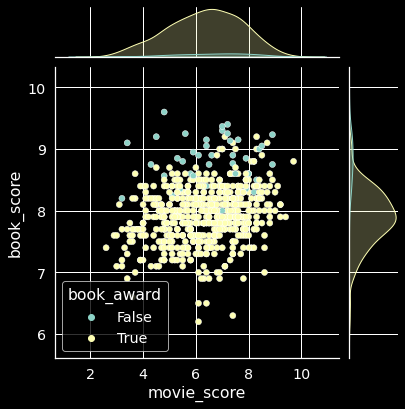

In [108]:
print(final_data['book_award'].value_counts())  # most movies are based on successful books
plt.style.use('dark_background')
sns.jointplot(data=final_data, x='movie_score', y='book_score', hue='book_award')

False    517
True      85
Name: movie_award, dtype: int64


Text(0.5, 49.99999999999995, 'movie score')

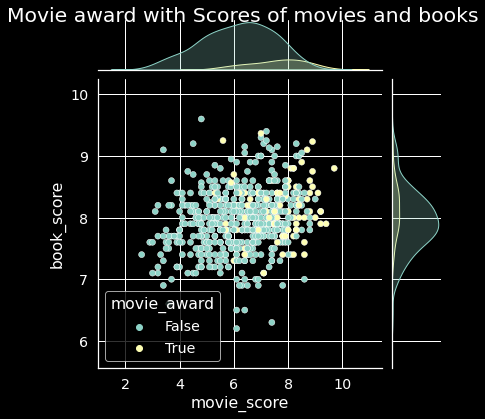

In [109]:
print(final_data['movie_award'].value_counts())  # most appreciated movies are more likely to have a movie award
plt.style.use('dark_background')
plt.rcParams.update({'font.size':17})
p=sns.jointplot(data=final_data, x='movie_score', y='book_score', hue='movie_award')
p.fig.subplots_adjust(top=0.95)
plt.suptitle('Movie award with Scores of movies and books') 
plt.ylabel('book score')
plt.xlabel('movie score')

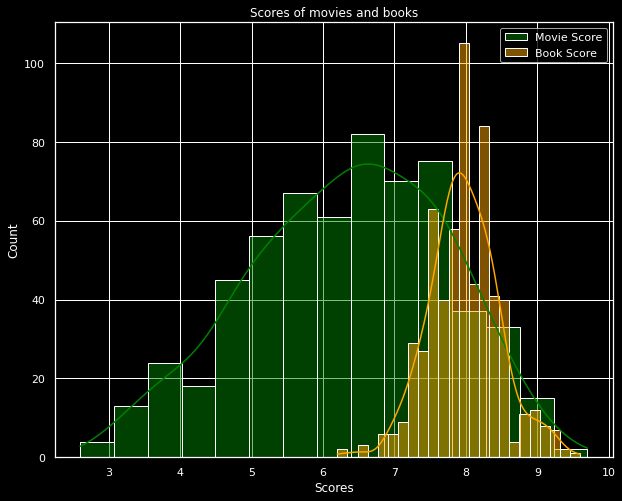

In [110]:
sns.set(style="darkgrid")
plt.style.use('dark_background')

sns.histplot(data=final_data, x="movie_score", color="green", label="Movie Score", kde=True)
sns.histplot(data=final_data, x="book_score", color="orange", label="Book Score", kde=True)

plt.title('Scores of movies and books')
plt.xlabel('Scores')
plt.legend() 
plt.show()

In [111]:
final_data['movie_score'].describe()

count    602.000000
mean       6.340365
std        1.387650
min        2.600000
25%        5.325000
50%        6.400000
75%        7.400000
max        9.700000
Name: movie_score, dtype: float64

In [112]:
final_data['book_score'].describe()   # mean of book scores are higher

count    602.000000
mean       7.975388
std        0.496537
min        6.200000
25%        7.700000
50%        8.000000
75%        8.300000
max        9.600000
Name: book_score, dtype: float64

To check whether this difference is significant or not, we performed a paired t-test (as they are related). And we found a really significant p value. Thus, book scores are significantly higher than movie scores.

In [113]:
stats.ttest_rel(final_data['movie_score'], final_data['book_score'])

Ttest_relResult(statistic=-29.587545966910607, pvalue=2.1343679307023946e-119)

In [114]:
# path= "drive/MyDrive/ADA/Adata"
# final_data.to_csv(os.path.join(path,r'final_data.csv'))

## APPENDIX 
fuzzymatcher

In [115]:
df_test = fuzzymatcher.fuzzy_left_join(dfm, clean_full_book2, left_on='book_label', right_on='title')  # trial fuzzy
df_test.head()

,best_match_score,__id_left,__id_right,movie_name,freebase_id,movie_score,movie_award,book_label,based_on_book,title,isbn,book_score,book_award
0,NaN,0_left,None,Ghosts of Mars,/m/03vyhn,3.8,NaN,NaN,False,NaN,NaN,NaN,NaN
1,NaN,1_left,None,White Of The Eye,/m/0285_cd,5.8,NaN,NaN,False,NaN,NaN,NaN,NaN
2,NaN,2_left,None,Alexander's Ragtime Band,/m/02qc0j7,7.0,True,NaN,False,NaN,NaN,NaN,NaN
3,NaN,3_left,None,City of the Dead,/m/075f66,5.9,NaN,NaN,False,NaN,NaN,NaN,NaN
4,0.495971,4_left,983_right,Henry V,/m/016ywb,8.2,True,henry v,True,henry v,0743484878,7.7,True


In [118]:
new_df_matching = df_test[df_test['best_match_score'] >= 0.4]
not_df_matching = df_test[df_test['best_match_score'] < 0.75]

In [119]:
not_df_matching.head()

,best_match_score,__id_left,__id_right,movie_name,freebase_id,movie_score,movie_award,book_label,based_on_book,title,isbn,book_score,book_award
4,0.495971,4_left,983_right,Henry V,/m/016ywb,8.2,True,henry v,True,henry v,0743484878,7.70,True
23,0.575018,23_left,2240_right,The Great Santini,/m/015wmt,8.0,NaN,the great santini,True,the great santini,0553746847,8.30,True
30,-0.143475,30_left,1778_right,Straw Dogs,/m/01bwgr,8.5,NaN,the siege of trenchers farm,True,siege and storm,None,8.35,False
169,0.054336,43_left,2105_right,The Dark Half,/m/0d_ng1,5.8,NaN,the dark half,True,the dark hours,None,9.40,False
178,0.091934,44_left,1367_right,Midnight Express,/m/0p_sc,7.6,True,midnight express,True,midnight,0060744510,8.60,True


In [120]:
new_df_matching.head()

,best_match_score,__id_left,__id_right,movie_name,freebase_id,movie_score,movie_award,book_label,based_on_book,title,isbn,book_score,book_award
4,0.495971,4_left,983_right,Henry V,/m/016ywb,8.2,True,henry v,True,henry v,0743484878,7.7,True
23,0.575018,23_left,2240_right,The Great Santini,/m/015wmt,8.0,NaN,the great santini,True,the great santini,0553746847,8.3,True
195,0.625196,48_left,1286_right,Lord of the Flies,/m/0kvfd1,8.2,NaN,lord of the flies,True,lord of the flies,0399501487,8.3,False
877,0.951270,111_left,1804_right,Snow Falling on Cedars,/m/060__7,5.3,NaN,snow falling on cedars,True,snow falling on cedars,067976402X,7.7,True
967,0.802088,129_left,2296_right,The House of Mirth,/m/03np63f,7.1,NaN,the house of mirth,True,the house of mirth,1844082938,7.9,True


In [121]:
rearranged_worst_matches=new_df_matching.sort_values(by=['best_match_score'],
                                  ascending=True)
rearranged_worst_matches.head(3)

,best_match_score,__id_left,__id_right,movie_name,freebase_id,movie_score,movie_award,book_label,based_on_book,title,isbn,book_score,book_award
83173,0.405742,12844_left,26_right,52 Pick-Up,/m/02p4c1j,5.9,NaN,52 pickup,True,52 pickup,0753819627,7.90,True
86149,0.408332,13285_left,2406_right,The Longest Day,/m/04v89z,7.8,True,the longest day,True,the longest ride,9781455520633,8.85,False
18240,0.408553,2512_left,2998_right,Watchmen,/m/0czyxs,6.4,NaN,watchmen,True,watchmen,0930289234,9.15,False


In [122]:
clean_matching = new_df_matching.drop_duplicates(subset=['book_label']) 
clean_matching.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515 entries, 4 to 92155
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   best_match_score  515 non-null    float64
 1   __id_left         515 non-null    object 
 2   __id_right        515 non-null    object 
 3   movie_name        515 non-null    object 
 4   freebase_id       515 non-null    object 
 5   movie_score       515 non-null    float64
 6   movie_award       76 non-null     object 
 7   book_label        515 non-null    object 
 8   based_on_book     515 non-null    bool   
 9   title             515 non-null    object 
 10  isbn              441 non-null    object 
 11  book_score        515 non-null    float64
 12  book_award        515 non-null    object 
dtypes: bool(1), float64(3), object(9)
memory usage: 52.8+ KB


In [123]:
# import os
# path= "drive/MyDrive/ADA/Adata"
# new_df_matching.to_csv(os.path.join(path,r'final_match.csv'))

In [124]:
new_df_matching.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 633 entries, 4 to 92155
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   best_match_score  633 non-null    float64
 1   __id_left         633 non-null    object 
 2   __id_right        633 non-null    object 
 3   movie_name        633 non-null    object 
 4   freebase_id       633 non-null    object 
 5   movie_score       633 non-null    float64
 6   movie_award       96 non-null     object 
 7   book_label        633 non-null    object 
 8   based_on_book     633 non-null    bool   
 9   title             633 non-null    object 
 10  isbn              528 non-null    object 
 11  book_score        633 non-null    float64
 12  book_award        633 non-null    object 
dtypes: bool(1), float64(3), object(9)
memory usage: 64.9+ KB


In [125]:
new_df_matching['best_match_score'].describe()

count    633.000000
mean       0.696097
std        0.226630
min        0.405742
25%        0.516586
50%        0.644570
75%        0.828346
max        1.857048
Name: best_match_score, dtype: float64